In [1]:
import pandas as pd

import pprint
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from sklearn.model_selection import train_test_split

from langchain_openai import ChatOpenAI

In [2]:
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path='../Paper1-RAGG/impl/.env')

### OpenAI
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### Load and Test TTPXHunter

In [3]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pickle
import torch
import os

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/hamzicd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Load the model and tokenizer from the Hugging Face Hub
model = RobertaForSequenceClassification.from_pretrained("nanda-rani/TTPXHunter")
tokenizer = RobertaTokenizer.from_pretrained("nanda-rani/TTPXHunter")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Copy the model to the GPU.
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [5]:
def extract_ttp_from_sentences(sentences, threshold, label_dict, ttpid2name):
    """
    Extract TTP (Tactics, Techniques, and Procedures) based on a prediction threshold from the given sentences.

    Args:
    - sentences (list of str): List of sentences to extract TTP from.
    - threshold (float): Confidence threshold for accepting predictions.

    Returns:
    - unique_ttp_ids (list of int): Unique TTP IDs extracted from the sentences.
    - names_for_ttp_ids (list of str): Human-readable names corresponding to the TTP IDs.
    """
    predictions = []

    # Loop over sentences and perform inference
    for text in sentences:
        # Tokenize the input text
        inputs = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)

        # Perform inference without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract logits and compute probabilities
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        max_prob, predicted_class_indices = torch.max(probabilities, dim=1)

        # Filter predictions based on the confidence threshold
        predicted_labels = [
            model.config.id2label[class_idx.item()]
            for prob, class_idx in zip(max_prob, predicted_class_indices)
            if prob.item() > threshold
        ]

        predictions.extend(predicted_labels)

    # Map the predicted labels to integer labels
    mapped_labels = [int(label.split('_')[1]) for label in predictions]

    # Load the label-to-name dictionary
    with open(label_dict, 'rb') as file:
        label_dict = pickle.load(file)

    # Invert the dictionary to map integer labels to TTP names
    inverted_label_dict = {v: k for k, v in label_dict.items()}
    ttp_list = [inverted_label_dict[label] for label in mapped_labels]

    # Extract unique TTP IDs
    unique_ttp_ids = list(set(ttp_list))

    # Translate TTP IDs to their names
    names_for_ttp_ids = translate_ttp_ids_to_names(unique_ttp_ids, ttpid2name)

    return unique_ttp_ids, names_for_ttp_ids

def remove_consecutive_newlines(text):
    """
    Remove consecutive newlines from a string.

    Args:
    - text (str): Input string with potential consecutive newlines.

    Returns:
    - str: String with consecutive newlines reduced to single newlines.
    """
    cleaned_text = text[0]
    for char in text[1:]:
        if not (char == cleaned_text[-1] and cleaned_text[-1] == '\n'):
            cleaned_text += char
    return cleaned_text

def process_text_file_for_attack_patterns(file_name, threshold, label_dict, ttpid2name):
    """
    Read and process a text file to extract attack patterns using TTP extraction.

    Args:
    - file_name (str): Path to the input text file.
    - threshold (float): Confidence threshold for TTP extraction.

    Returns:
    - tuple: (unique TTP IDs, names corresponding to TTP IDs).
    """
    sentences = []

    # Read the text file
    with open(file_name, 'r', encoding='utf-8') as file:
        text = file.read()

    # Clean the text by removing consecutive newlines and tabs
    text = remove_consecutive_newlines(text)
    text = text.replace('\t', ' ').replace("\'", "'")

    # Tokenize sentences
    tokenized_sentences = nltk.sent_tokenize(text)

    # Split tokenized sentences by newlines and filter empty lines
    for sentence in tokenized_sentences:
        sentences += [line for line in sentence.split('\n') if len(line) > 0]

    # Extract TTP from the processed sentences
    return extract_ttp_from_sentences(sentences, threshold, label_dict, ttpid2name)

def translate_ttp_ids_to_names(ttp_ids, ttpid2name):
    """
    Translate TTP (Tactics, Techniques, and Procedures) IDs to human-readable names.

    Args:
    - ttp_ids (list of int): List of TTP IDs to translate.

    Returns:
    - list of str: Corresponding human-readable names for the TTP IDs.
    """
    # Load the TTP ID to name mapping from a file
    with open(ttpid2name, 'rb') as file:
        id_to_name_map = pickle.load(file)

    # Translate each TTP ID to its corresponding name
    ttp_names = [id_to_name_map[ttp_id] for ttp_id in ttp_ids if ttp_id in id_to_name_map]

    return ttp_names


In [6]:
label_dict = 'label_dict.pkl'
ttpid2name = 'ttp_id_name.pkl'
report = "SharpPanda_APT_Campaign_Expands_its_Arsenal_Targeting_G20_Nations.txt"
th = 0.644

ttps, ttp_names = process_text_file_for_attack_patterns(report, th, label_dict, ttpid2name)
print(len(ttps))

for i in range(len(ttps)):
  print(ttps[i], " - ", ttp_names[i])

19
T1218  -  System Binary Proxy Execution
T1480  -  Execution Guardrails
T1140  -  Deobfuscate/Decode Files or Information
T1560  -  Archive Collected Data
T1005  -  Data from Local System
T1205  -  Traffic Signaling
T1082  -  System Information Discovery
T1588  -  Obtain Capabilities
T1105  -  Ingress Tool Transfer
T1568  -  Dynamic Resolution
T1036  -  Masquerading
T1203  -  Exploitation for Client Execution
T1587  -  Develop Capabilities
T1027  -  Obfuscated Files or Information
T1566  -  Phishing
T1041  -  Exfiltration Over C2 Channel
T1531  -  Account Access Removal
T1210  -  Exploitation of Remote Services
T1119  -  Automated Collection


### Load and Test FewShotTTP (TTF-Shot)

In [3]:
df_train = pd.read_csv('./TTPFShot-training-data.csv')
df_train.head()

Key                                              Value
0      T1094         Some Software variants use raw TCP for C2.
1      T1047  Software leverages WMI to enumerate anti-virus...
2  T1003.001  Software contains an implementation of Softwar...
3  T1614.001  Attacker has used implants to collect the syst...
4  T1587.001                     For Software modular backdoor.

In [7]:
df_train.to_csv("./TTPFShot-training-data-custom-sep.csv", index=False, sep=';')

In [6]:
len(set(df_train.Key))

780

In [8]:
### embedding
model2 = "ehsanaghaei/SecureBERT"
embeddings2 = HuggingFaceEmbeddings(model_name = model2)

/tmp/ipykernel_2795732/3801564067.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings2 = HuggingFaceEmbeddings(model_name = model2)
No sentence-transformers model found with name ehsanaghaei/SecureBERT. Creating a new one with mean pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at ehsanaghaei/SecureBERT and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hamzicd/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_sp

In [9]:
docs2 = []
for index, row in df_train.iterrows():
    doc = Document(page_content=row["Value"], metadata={"TTP_ID": row["Key"]})
    docs2.append(doc)

print(len(docs2))

19747


In [12]:
### init vector DB
#db2 = FAISS.from_documents(docs2, embeddings2)

In [13]:
#db2.save_local("./TTPFShot-training-data-19747")

In [10]:
db3 = FAISS.load_local("./TTPFShot-training-data-19747", embeddings2, allow_dangerous_deserialization=True)

## TTPFShot - Classification Approach

In [29]:
### Predicting single TTP label
def predict_label(text_to_predict, train_vector_db, llm):
    ##### Prompt 1
    search_results = train_vector_db.similarity_search_with_score(text_to_predict, k=65)

    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = """You are an expert in MITRE ATT&CK TTP classification.
    Your task is to classify the 'InputText' based on the provided examples below.
    Each example shows a sentence, inverse similarity to InputText (the lower the better),
    and its corresponding classification label starting with 'T'.
    Use these examples to determine the correct classification for the given text (InputText).
    If 'InputText' is completely not related to any of the provided examples, return class 'T0000'.
    To determine if the 'InputText' is not related to the given examples, you can use the 'Similarity' propery of the examples.
    Low 'Similarity' values indicate the high similarity in strings.
    Return only the classification label starting with 'T' or 'T0000' if you found no appropriate class for 'InputText'.\n""" + xs
    
    #####
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label


### Predicting single TTP label
def predict_label1(text_to_predict, train_vector_db, llm):
    ##### Prompt 1
    search_results = train_vector_db.similarity_search_with_score(text_to_predict, k=65)

    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = """You are an expert in MITRE ATT&CK TTP classification.
    Your task is to classify the 'InputText' based on the provided examples below.
    
    Each example includes:
        - A sentence.
        - An inverse similarity score with the 'InputText' (lower scores indicate higher similarity).
        - A corresponding classification label starting with 'T'.
    
    Use these examples to determine the correct classification for the given text (InputText).
    
    If 'InputText' is completely not related to any of the provided examples, return class 'T0000'.
    To determine if the 'InputText' is not related to the given examples, you can use the 'Similarity' propery of the examples.
    Low 'Similarity' values indicate the high similarity in strings.
    Return only the classification label starting with 'T' or 'T0000' if you found no appropriate class for 'InputText'.\n""" + xs
    
    #####
    #**Think through the classification process step-by-step, comparing the 'InputText' to each example, but do not share your reasoning.**
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label


### Enable predicting of Multiple TTP Labels
def predict_label2(text_to_predict, train_vector_db, llm):
    ##### Prompt 1
    search_results = train_vector_db.similarity_search_with_score(text_to_predict, k=65)

    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = """You are an expert in MITRE ATT&CK TTP classification. 
    Your task is to classify the 'InputText' based on the examples provided below.

        Each example includes:
        
        - A sentence.
        - An inverse similarity score with the 'InputText' (lower scores indicate higher similarity).
        - A corresponding classification label starting with 'T'.
        
        Use these examples to determine the correct classification label(s) for the given 'InputText'.
        If 'InputText' is completely unrelated to any of the examples, return the classification label 'T0000'.
        
        To determine if 'InputText' is unrelated, refer to the 'Similarity' property of the examples.
        Lower similarity values indicate greater similarity between strings.
        
        Return only the classification label(s) starting with 'T'.
        If multiple classifications apply, list them in the format: T1111, T2222, ...".
        If no appropriate classification is found, return 'T0000'.
        Do not return anything but the classification labels!\n""" + xs
    
    #####
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label

### Zero-Shot Predictions
def predict_label_zero(text_to_predict, llm):
    ##### Prompt 1
    #search_results = train_vector_db.similarity_search_with_score(text_to_predict, k=65)

    
    #xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 2]
    #xs = ["\nText:'"+ doc.page_content.lower().strip()+"'\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results]
    

    
    xs = """You are an expert in MITRE ATT&CK TTP classification. 
    Your task is to classify the 'InputText'.

        If 'InputText' is completely unrelated to cybersecurity, return the classification label 'T0000'.
        
        Return only the classification label(s) starting with 'T'.
        If no appropriate classification is found, return 'T0000'.
        Do not return anything but the classification label!\n"""# + xs
    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    
    #####
    
    #print(xs)
    prompt = xs
    result = llm.invoke(prompt)
    predicted_label = result.content
    return predicted_label

In [30]:
from typing import Literal

def ttf_shot_predict(sentences, option: Literal["SINGLE_LABEL", "COT", "MULTIPLE_LABEL", "ZERO_SHOT"], llm, db):
    predicted_labels = []
    # Iterating over the DataFrame row by row
    for sentence in sentences:
        
        match option:
            # single label
            case "SINGLE_LABEL":
                predicted_label = predict_label1(sentence, db, llm)
            # multiple label
            case "MULTIPLE_LABEL":
                predicted_label = predict_label2(sentence, db, llm)
            # zero shot
            case "ZERO_SHOT":
                predicted_label = predict_label_zero(sentence, llm)
            case _:
                raise ValueError("Invalid option")
            
        predicted_labels.append(predicted_label)
        #predicted_labels.extend(predicted_label)

    cleaned_labels = [label.replace('Classification:', '') for label in predicted_labels]
    cleaned_labels_set = set(cleaned_labels)
    cleaned_labels_set.discard('T0000') #  remove empty classification
    #print(cleaned_labels_set)
    return cleaned_labels_set

### Precheck

In [31]:
txt = """ 
Subsequently, the loader encrypts the collected information using RC4 encryption with the key “xkYgv127” and encodes it using base64.
The encrypted data is then exfiltrated using the below C&C URL: hxxps://13[.]236[.]189[.]80:8001/G0AnyWhere_up[.]jsp?Data=[redacted] The figure below illustrates the exfiltrated data sent to the C&C server, as well as the decrypted/decoded stolen information obtained from the victim’s machine. 
Figure 7 – Exfiltrated data to C&C server Final Payload Once the victim’s information is sent to the remote server, the TA checks the information.
If they deem the victim’s machine to be intriguing, the C&C server responds with the next stage executable.
During the final phase of the infection chain, the malicious loader in the SharpPanda APT campaign is specifically designed to download a backdoor module.
However, during our analysis, no response was received from the remote server. 
In previous SharpPanda APT campaigns, the loader establishes a connection with a C&C server in the final stage of the attack.
Subsequently, it downloads and executes a malicious backdoor. 
C:\\windows\\dllhost.dat Credential theft module Written as a .tmp file to the temp directory Ransomware splash and warning files Command Line Execution. 
"""

# T1082, T1049
txt2 = """
Payload scans system and network for system information and network connection discovery
"""

In [32]:

llm = ChatOpenAI(model="gpt-4o", temperature=0)


In [33]:
print("SINGLE_LABEL:", ttf_shot_predict(sent_tokenize(txt2), "SINGLE_LABEL", llm, db3))
print("MULTIPLE_LABEL:", ttf_shot_predict(sent_tokenize(txt2), "MULTIPLE_LABEL", llm, db3))
print("ZERO_SHOT:", ttf_shot_predict(sent_tokenize(txt2), "ZERO_SHOT", llm, db3))

SINGLE_LABEL: {'T1049'}
MULTIPLE_LABEL: {'T1082, T1049'}
ZERO_SHOT: {'T1016'}


In [34]:
print("ZERO_SHOT:", ttf_shot_predict(sent_tokenize(txt), "ZERO_SHOT", llm, db3))

ZERO_SHOT: {'T1059', 'T1204', 'T1105', 'T1027', 'T1041'}


In [35]:
print("SINGLE_LABEL:", ttf_shot_predict(sent_tokenize(txt), "SINGLE_LABEL", llm, db3))

SINGLE_LABEL: {'T1105', 'T1071.001', 'T1560.003', 'T1041', 'T1059.003'}


In [36]:
print("ZERO_SHOT:", ttf_shot_predict(sent_tokenize(txt), "ZERO_SHOT", llm, db3))

ZERO_SHOT: {'T1059', 'T1204', 'T1105', 'T1027', 'T1041'}


In [37]:
print("MULTIPLE_LABEL:", ttf_shot_predict(sent_tokenize(txt), "MULTIPLE_LABEL", llm, db3))

MULTIPLE_LABEL: {'T1059', 'T1105', 'T1071.001', 'T1560.003', 'T1041', 'T1140'}


### Load Report Dataset

In [38]:
df_reports = pd.read_csv("../TTP-crawler/CISA-crawl-rt-ttp-ct.csv")
df_reports

Unnamed: 0  \
0   https://www.cisa.gov/news-events/cybersecurity...   
1   https://www.cisa.gov/news-events/cybersecurity...   
2   https://www.cisa.gov/news-events/cybersecurity...   
3   https://www.cisa.gov/news-events/cybersecurity...   
4   https://www.cisa.gov/news-events/cybersecurity...   
..                                                ...   
72  https://www.cisa.gov/news-events/cybersecurity...   
73  https://www.cisa.gov/news-events/cybersecurity...   
74  https://www.cisa.gov/news-events/cybersecurity...   
75  https://www.cisa.gov/news-events/cybersecurity...   
76  https://www.cisa.gov/news-events/cybersecurity...   

                                              RawText  \
0   \n\n\n\n\n\n\nActions to take today to mitigat...   
1   \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2   \n\n\n\n\n\n\nActions to take today to mitigat...   
3   \n\n\n\n\n\n\nActions to take today to mitigat...   
4   \n\n\n\n\n\n\nActions to take today to mitigat...   
..                                                ...   
72  \n\n\n\n\nSummary\n\nThis joint cybersecurity ...   
73  \n\n\n\n\nSummary\n\nThis Alert uses the MITRE...   
74  \n\n\n\n\nSummary\n\nThis Alert uses the MITRE...   
75  \n\n\n\n\nSummary\n\nThis Alert uses the MITRE...   
76  \n\n\n\n\nSummary\n\nThis advisory uses the MI...   

                                                  TTP  \
0   {'T1083', 'T1071.002', 'T1055.004', 'T1657', '...   
1   {'T1621', 'T1090.002', 'T1110', 'T1078.004', '...   
2   {'T1021.007', 'T1083', 'T1087.002', 'T1552.001...   
3   {'TA0003', 'TA0008', 'T1083', 'T1654', 'T1078....   
4   {'TA0006', 'T1595.002', 'T1190', 'T1083', 'T15...   
..                                                ...   
72  {'TA0003', 'T1190', 'TA0008', 'T1110', 'T1189'...   
73  {'T1041', 'T1573.002', 'T1566.002', 'T1021.002...   
74  {'T1041', 'T1055.012', 'T1027.002', 'T1546.008...   
75  {'T1083', 'T1016', 'T1036.005', 'T1105', 'T108...   
76  {'T1498', 'TA0010', 'T1499', 'T1253', 'T1190',...   

                                            CleanText  
0   \n\n\n\n\n\n\nActions to take today to mitigat...  
1   \n\n\n\nHow SVR-Attributed Actors are Adapting...  
2   \n\n\n\n\n\n\nActions to take today to mitigat...  
3   \n\n\n\n\n\n\nActions to take today to mitigat...  
4   \n\n\n\n\n\n\nActions to take today to mitigat...  
..                                                ...  
72  \n\n\n\n\nSummary\n\nThis joint cybersecurity ...  
73  \n\n\n\n\nSummary\n\nThis Alert uses the MITRE...  
74  \n\n\n\n\nSummary\n\nThis Alert uses the MITRE...  
75  \n\n\n\n\nSummary\n\nThis Alert uses the MITRE...  
76  \n\n\n\n\nSummary\n\nThis advisory uses the MI...  

[77 rows x 4 columns]

In [39]:
#df_reports = df_reports.head(15)

## DSC Benchmarking - TTPXHunter vs. TTPFShot

In [40]:
import time

df_reports["ttpxhunter"] = ""
df_reports["ttpfshot_sl"] = ""
df_reports["ttpfshot_ml"] = ""
df_reports["ttpfshot_zs"] = ""

for index, row in df_reports.iterrows():
    #print(f"Index: {index}")
    print("text nr: ", index)
    
    text_to_classify = row["CleanText"]
    
    start_time = time.time()
    ttpfshot_sl = ttf_shot_predict(sent_tokenize(text_to_classify), "SINGLE_LABEL", llm, db3)
    elapsed_time = (time.time() - start_time)/60
    print(f"ttpfshot_sl done in: {elapsed_time} minutes")
    
    start_time = time.time()
    ttpfshot_ml = ttf_shot_predict(sent_tokenize(text_to_classify), "MULTIPLE_LABEL", llm, db3)
    elapsed_time = (time.time() - start_time)/60
    print(f"ttpfshot_ml done in: {elapsed_time} minutes")
    
    start_time = time.time()
    ttpfshot_zs = ttf_shot_predict(sent_tokenize(text_to_classify), "ZERO_SHOT", llm, db3)
    elapsed_time = (time.time() - start_time)/60
    print(f"ttpfshot_zs done in: {elapsed_time} minutes")
    
    start_time = time.time()
    ttps, ttp_names = extract_ttp_from_sentences(sent_tokenize(text_to_classify), th, label_dict, ttpid2name)#(text_to_classify, th, label_dict, ttpid2name)
    elapsed_time = (time.time() - start_time)/60
    print(f"ttpxhunter done in: {elapsed_time} minutes")
    
    ### save results to the reports dataframe
    df_reports.at[index, 'ttpxhunter'] = ttps
    df_reports.at[index, 'ttpfshot_sl'] = ttpfshot_sl
    df_reports.at[index, 'ttpfshot_ml'] = ttpfshot_ml
    df_reports.at[index, 'ttpfshot_zs'] = ttpfshot_zs
   
    
    #print("ttpxhunter:", ttps)
    print("ttpxhunter:", ttps)
    print("ttpfshot_sl:", ttpfshot_sl)
    print("ttpfshot_ml:", ttpfshot_ml)
    print("ttpZshot_zs:", ttpfshot_zs)
    
    #TTPFShot
    

text nr:  0
ttpfshot_sl done in: 3.0754018902778624 minutes
ttpfshot_ml done in: 2.4491556684176126 minutes
ttpfshot_zs done in: 1.5548407236735027 minutes
ttpxhunter done in: 0.6120125850041708 minutes
ttpxhunter: ['T1218', 'T1490', 'T1048', 'T1213', 'T1104', 'T1482', 'T1547', 'T1140', 'T1560', 'T1553', 'T1542', 'T1071', 'T1567', 'T1205', 'T1591', 'T1201', 'T1548', 'T1528', 'T1136', 'T1486', 'T1562', 'T1587', 'T1059', 'T1003', 'T1020', 'T1029', 'T1027', 'T1531']
ttpfshot_sl: {'T1490', 'T1588.002', 'T1598.004', 'T1078.002', 'T1102.002', 'T1548.002', 'T1555.005', 'T1591.001', 'T1563', 'T1059.003', 'T1070', 'T1140', 'T1553.006', 'T1597.002', 'T1518.001', 'T1003.005', 'T1657', 'T1005', 'T1110.003', 'T1591', 'T1560.001', 'T1055.001', 'T1218.005', 'T1201', 'T1016', 'T1136.001', 'T1556.002', 'T1597.001', 'T1076', 'T1021', 'T1111', 'T1547.001', 'T1105', 'T1219', 'T1137.005', 'T1070.004', 'T1562.001', 'T1562.009', 'T1486', 'T1048.003', 'T1548.003', 'T1599', 'T1202', 'T1110.001', 'T1562.004', '

ttpfshot_sl done in: 1.960671635468801 minutes
ttpfshot_ml done in: 1.9199054678281149 minutes
ttpfshot_zs done in: 0.8362875739733379 minutes
ttpxhunter done in: 0.527725879351298 minutes
ttpxhunter: ['T1071', 'T1594', 'T1083', 'T1593', 'T1102', 'T1530', 'T1213', 'T1573', 'T1587', 'T1583', 'T1571', 'T1553']
ttpfshot_sl: {'T1555.006', 'T1552', 'T1071.001', 'T1583.003', 'T1505.003', 'T1553.006', 'T1556.005', 'T1518.001', 'T1596.004', 'T1550.004', 'T1078', 'T1071.003', 'T1589.002', 'T1102', 'T1587.001', 'T1016', 'T1595.003', 'T1190', 'T1555', 'T1608.005', 'T1611', 'T1098.001', 'T1597.001', 'T1105', 'T1589', 'T1070.004', 'T1580', 'T1203', 'T1552.001', 'T1608.001', 'T1083', 'T1595.002', 'T1046', 'T1562.010', 'T1119', 'T1562.002'}
ttpfshot_ml: {'T1555.006', 'T1552', 'T1071.001', 'T1584.001', 'T1583.003', 'T1505.003', 'T1480.001', 'T1556.005', 'T1518.001', 'T1596.004', 'T1550.004', 'T1622', 'T1078', 'T1005', 'T1071.003', 'T1589.002', 'T1070.002', 'T1102', 'T1016', 'T1595.003', 'T1190', 'T158

ttpfshot_sl done in: 1.6021013975143432 minutes
ttpfshot_ml done in: 1.7637413382530212 minutes
ttpfshot_zs done in: 0.7006482799847921 minutes
ttpxhunter done in: 0.34191266298294065 minutes
ttpxhunter: ['T1550', 'T1565', 'T1587', 'T1588', 'T1204', 'T1078', 'T1199', 'T1114', 'T1534', 'T1531', 'T1585', 'T1583', 'T1586', 'T1195']
ttpfshot_sl: {'T1114.003', 'T1591.002', 'T1585.001', 'T1585.002', 'T1564.008', 'T1591.001', 'T1110.004', 'T1598', 'T1593.001', 'T1078', 'T1591.004', 'T1591', 'T1589.002', 'T1566.001', 'T1566.003', 'T1539', 'T1111', 'T1589', 'T1566.002', 'T1598.003', 'T1583.001', 'T1586.002', 'T1552.001', 'T1566', 'T1562.002'}
ttpfshot_ml: {'T1114.003', 'T1585.001', 'T1566, T1598', 'T1585.002', 'T1564.008', 'T1591.001', 'T1566.003, T1194', 'T1110.004', 'T1556.005', 'T1598', 'T1593.001', 'T1078', 'T1589.002', 'T1566.003', 'T1566.001', 'T1539', 'T1597.001', 'T1111', 'T1589', 'T1566.002', 'T1598.003', 'T1583.001', 'T1566.001, T1566.002', 'T1586.002', 'T1597', 'T1552.001', 'T1614', 

ttpfshot_sl done in: 2.938061249256134 minutes
ttpfshot_ml done in: 2.9440263430277507 minutes
ttpfshot_zs done in: 1.4796377420425415 minutes
ttpxhunter done in: 0.5987242499987284 minutes
ttpxhunter: ['T1218', 'T1213', 'T1482', 'T1070', 'T1078', 'T1591', 'T1585', 'T1588', 'T1021', 'T1219', 'T1119', 'T1573', 'T1486', 'T1562', 'T1587', 'T1059', 'T1083', 'T1074', 'T1029', 'T1018', 'T1027', 'T1566', 'T1531', 'T1583']
ttpfshot_sl: {'T1588.002', 'T1086', 'T1078.002', 'T1133', 'T1585.002', 'T1563', 'T1059.003', 'T1068', 'T1055', 'T1553.006', 'T1518.001', 'T1556.006', 'T1078', 'T1027.004', 'T1657', 'T1016', 'T1190', 'T1598.002', 'T1096', 'T1082', 'T1036.005', 'T1548', 'T1597.001', 'T1111', 'T1555.004', 'T1070.003', 'T1070.004', 'T1036.004', 'T1599', 'T1562.001', 'T1486', 'T1548.003', 'T1106', 'T1583.001', 'T1110.001', 'T1608.002', 'T1562.004', 'T1021.001', 'T1608.001', 'T1059', 'T1578.004', 'T1070.007', 'T1070.001', 'T1087', 'T1083', 'T1069.002', 'T1484.002', 'T1562.003', 'T1018', 'T1027', '

ttpfshot_sl done in: 2.8688802162806195 minutes
ttpfshot_ml done in: 3.1375245690345763 minutes
ttpfshot_zs done in: 1.3372342427571615 minutes
ttpxhunter done in: 0.907534388701121 minutes
ttpxhunter: ['T1213', 'T1104', 'T1482', 'T1480', 'T1070', 'T1553', 'T1205', 'T1548', 'T1528', 'T1136', 'T1036', 'T1562', 'T1587', 'T1059', 'T1114', 'T1029', 'T1027', 'T1531', 'T1119']
ttpfshot_sl: {'T1490', 'T1218', 'T1588.002', 'T1598.004', 'T1072', 'T1133', 'T1555.005', 'T1585.002', 'T1563', 'T1059.003', 'T1070', 'T1553.006', 'T1597.002', 'T1518.001', 'T1078', 'T1657', 'T1005', 'T1589.002', 'T1201', 'T1587.001', 'T1016', 'T1555.003', 'T1136.001', 'T1190', 'T1057', 'T1108', 'T1036.005', 'T1556.002', 'T1597.001', 'T1111', 'T1076', 'T1562.007', 'T1070.004', 'T1137.005', 'T1058', 'T1036', 'T1562.001', 'T1486', 'T1548.003', 'T1599', 'T1583.001', 'T1110.001', 'T1562.004', 'T1021.001', 'T1070.001', 'T1083', 'T1589.001', 'T1027', 'T1556.', 'T1583.006', 'T1562.002'}
ttpfshot_ml: {'T1490', 'T1588.002', 'T15

ttpfshot_sl done in: 3.3045209447542825 minutes
ttpfshot_ml done in: 3.461368211110433 minutes
ttpfshot_zs done in: 1.5377183477083842 minutes
ttpxhunter done in: 0.8946290294329325 minutes
ttpxhunter: ['T1565', 'T1218', 'T1124', 'T1213', 'T1482', 'T1112', 'T1480', 'T1553', 'T1071', 'T1189', 'T1005', 'T1102', 'T1057', 'T1082', 'T1548', 'T1136', 'T1036', 'T1562', 'T1587', 'T1059', 'T1020', 'T1027', 'T1041', 'T1531', 'T1119', 'T1129']
ttpfshot_sl: {'T1490', 'T1584.002', 'T1588.002', 'T1086', 'T1548.002', 'T1555.005', 'T1071.001', 'T1059.001', 'T1055.012', 'T1573.001', 'T1027.011', 'T1033', 'T1553.006', 'T1518.001', 'T1003.005', 'T1078', 'T1204.001', 'T1567', 'T1556', 'T1556.006', 'T1055.001', 'T1550.002', 'T1201', 'T1016', 'T1190', 'T1001', 'T1057', 'T1136.001', 'T1082', 'T1548', 'T1588', 'T1111', 'T1105', 'T1219', 'T1566.002', 'T1546.008', 'T1070.003', 'T1204.002', 'T1036', 'T1027.013', 'T1562.001', 'T1548.003', 'T1486', 'T1119', 'T1583.001', 'T1202', 'T1110.001', 'T1562.004', 'T1021.00

ttpfshot_sl done in: 3.8458160956700644 minutes
ttpfshot_ml done in: 4.179822905858358 minutes
ttpfshot_zs done in: 1.8438184976577758 minutes
ttpxhunter done in: 0.894349233309428 minutes
ttpxhunter: ['T1213', 'T1482', 'T1480', 'T1135', 'T1560', 'T1553', 'T1078', 'T1005', 'T1211', 'T1057', 'T1585', 'T1548', 'T1588', 'T1528', 'T1136', 'T1069', 'T1219', 'T1115', 'T1562', 'T1587', 'T1059', 'T1003', 'T1020', 'T1029', 'T1027', 'T1566', 'T1531', 'T1119', 'T1491']
ttpfshot_sl: {'T1490', 'T1102.002', 'T1598.004', 'T1086', 'T1548.002', 'T1059.006', 'T1570', 'T1133', 'T1555.005', 'T1482', 'T1584.001', 'T1489', 'T1059.003', 'T1070', 'T1135', 'T1033', 'T1553.006', 'T1518.001', 'T1556.006', 'T1078', 'T1657', 'T1556', 'T1589.002', 'T1201', 'T1016', 'T1555.003', 'T1190', 'T1136.001', 'T1057', 'T1082', 'T1036.005', 'T1597.001', 'T1111', 'T1219', 'T1589', 'T1070.003', 'T1566.002', 'T1562.007', 'T1530', 'T1596', 'T1216', 'T1562.001', 'T1119', 'T1486', 'T1548.003', 'T1087.002', 'T1202', 'T1110.001', 'T1

ttpfshot_sl done in: 3.124776903788249 minutes
ttpfshot_ml done in: 2.946123504638672 minutes
ttpfshot_zs done in: 1.1734334429105122 minutes
ttpxhunter done in: 0.6058304826418559 minutes
ttpxhunter: ['T1218', 'T1490', 'T1213', 'T1112', 'T1070', 'T1140', 'T1497', 'T1553', 'T1102', 'T1201', 'T1057', 'T1082', 'T1548', 'T1588', 'T1036', 'T1587', 'T1059', 'T1020', 'T1498', 'T1029', 'T1027', 'T1531', 'T1119', 'T1129']
ttpfshot_sl: {'T1490', 'T1588.002', 'T1548.002', 'T1071.001', 'T1112', 'T1491.001', 'T1059.003', 'T1140', 'T1560', 'T1543.005', 'T1556.005', 'T1518.001', 'T1588.007', 'T1556', 'T1657', 'T1190', 'T1082', 'T1485', 'T1548.005', 'T1047', 'T1597.001', 'T1111', 'T1588', 'T1547.001', 'T1105', 'T1218.011', 'T1070.004', 'T1599', 'T1027.013', 'T1486', 'T1548.003', 'T1562.001', 'T1110.001', 'T1562.004', 'T1059', 'T1049', 'T1087', 'T1021.002', 'T1027.001', 'T1027', 'T1566', 'T1041', 'T1567.002', 'T1484.001', 'T1614.001', 'T1562.002', 'T1588.001', 'T1059.001'}
ttpfshot_ml: {'T1490', 'T158

ttpfshot_sl done in: 3.2458037376403808 minutes
ttpfshot_ml done in: 3.2959643522898356 minutes
ttpfshot_zs done in: 1.4762503226598105 minutes
ttpxhunter done in: 0.8571225802103678 minutes
ttpxhunter: ['T1565', 'T1124', 'T1213', 'T1482', 'T1480', 'T1140', 'T1134', 'T1553', 'T1189', 'T1588', 'T1528', 'T1021', 'T1602', 'T1036', 'T1119', 'T1203', 'T1587', 'T1114', 'T1029', 'T1027', 'T1531', 'T1530', 'T1583']
ttpfshot_sl: {'T1490', 'T1556.009', 'T1591.002', 'T1588.002', 'T1027.005', 'T1548.002', 'T1133', 'T1585.002', 'T1583.003', 'T1068', 'T1480.001', 'T1016.001', 'T1584.004', 'T1556.006', 'T1657', 'T1600', 'T1053.007', 'T1589.002', 'T1591', 'T1205', 'T1566.003', 'T1587.001', 'T1190', 'T1585', 'T1597.001', 'T1076', 'T1105', 'T1036', 'T1599', 'T1486', 'T1548.003', 'T1562.001', 'T1203', 'T1583.001', 'T1021.001', 'T1553.004', 'T1021.002', 'T1589.001', 'T1027', 'T1041', 'T1187', 'T1098', 'T1530', 'T1583', 'T1218.001', 'T1588.001'}
ttpfshot_ml: {'T1490', 'T1556.009', 'T1591.002', 'T1588.002',

ttpfshot_sl done in: 3.8930169781049093 minutes
ttpfshot_ml done in: 7.073112614949545 minutes
ttpfshot_zs done in: 1.6946794509887695 minutes
ttpxhunter done in: 0.6484583695729573 minutes
ttpxhunter: ['T1565', 'T1124', 'T1570', 'T1213', 'T1584', 'T1482', 'T1140', 'T1560', 'T1078', 'T1518', 'T1082', 'T1606', 'T1548', 'T1021', 'T1528', 'T1602', 'T1505', 'T1587', 'T1597', 'T1059', 'T1114', 'T1087', 'T1083', 'T1020', 'T1018', 'T1030', 'T1098', 'T1531', 'T1119']
ttpfshot_sl: {'T1565', 'T1078.002', 'T1059.006', 'T1133', 'T1583.003', 'T1059.003', 'T1518.001', 'T1064', 'T1556.006', 'T1078', 'T1518', 'T1005', 'T1560.001', 'T1567', 'T1087.001', 'T1602.002', 'T1560.002', 'T1114.001', 'T1016', 'T1190', 'T1057', 'T1108', 'T1548.005', 'T1047', 'T1597.001', 'T1219', 'T1098.002', 'T1036', 'T1599', 'T1562.001', 'T1548.003', 'T1203', 'T1078.003', 'T1059', 'T1078.001', 'T1114', 'T1049', 'T1083', 'T1074.001', 'T1197', 'T1021.002', 'T1041', 'T1040', 'T1098', 'T1046', 'T1210', 'T1119', 'T1571', 'T1059.001

ttpfshot_sl done in: 1.8358710408210754 minutes
ttpfshot_ml done in: 1.9077701489130656 minutes
ttpfshot_zs done in: 0.7337637503941854 minutes
ttpxhunter done in: 0.39260623455047605 minutes
ttpxhunter: ['T1059', 'T1548', 'T1136', 'T1498', 'T1213', 'T1568', 'T1482', 'T1016', 'T1486', 'T1562', 'T1531', 'T1587', 'T1583']
ttpfshot_sl: {'T1490', 'T1543.003', 'T1555.005', 'T1133', 'T1585.002', 'T1059.003', 'T1070', 'T1110.004', 'T1595.001', 'T1657', 'T1566.001', 'T1201', 'T1016', 'T1136.001', 'T1597.001', 'T1053.005', 'T1111', 'T1562.001', 'T1562.009', 'T1486', 'T1548.003', 'T1110.001', 'T1562.004', 'T1021.001', 'T1087', 'T1016.002', 'T1562.003', 'T1588.001'}
ttpfshot_ml: {'T1490', 'T1543.003', 'T1555.005', 'T1133', 'T1585.002', 'T1059.003, T1055', 'T1070', 'T1110.004', 'T1518.001', 'T1595.001', 'T1556.006', 'T1078', 'T1566.001', 'T1201', 'T1485', 'T1597.001', 'T1076', 'T1053.005', 'T1552.006', 'T1562.001', 'T1562.009', 'T1486', 'T1548.003', 'T1203', 'T1110.001', 'T1562.004', 'T1021.001', 

ttpfshot_sl done in: 1.875900888442993 minutes
ttpfshot_ml done in: 1.6940292119979858 minutes
ttpfshot_zs done in: 0.6555992444356282 minutes
ttpxhunter done in: 0.5257018287976583 minutes
ttpxhunter: ['T1495', 'T1124', 'T1570', 'T1213', 'T1480', 'T1531', 'T1587', 'T1119', 'T1571', 'T1553']
ttpfshot_sl: {'T1072', 'T1570', 'T1590.006', 'T1059.003', 'T1068', 'T1043', 'T1553.006', 'T1559.001', 'T1078', 'T1602.002', 'T1587.001', 'T0851', 'T0859', 'T1552.004', 'T1588.006', 'T1499.002', 'T1111', 'T1105', 'T1562.007', 'T1599', 'T1548.003', 'T1110.001', 'T1049', 'T1018', 'T1548.005', 'T1129', 'T1014'}
ttpfshot_ml: {'T1490', 'T1546.016', 'T0838', 'T1068', 'T1553.006', 'T0813', 'T1480.001', 'T1135', 'T1518.001', 'T1078', 'T1602.002', 'T0855', 'T1587.001', 'T1552.004', 'T1588.006', 'T1499.002', 'T1597.001', 'T1111', 'T1105', 'T1562.007', 'T1599', 'T1548.003', 'T1110.001', 'T1059', 'T1003', 'T1569', 'T1648', 'T1021.002', 'T1018', 'T1078, T1569', 'T1514', 'T1040', 'T1046', 'T1014'}
ttpZshot_zs: {'

ttpfshot_sl done in: 3.8372379581133527 minutes
ttpfshot_ml done in: 3.2938564380009967 minutes
ttpfshot_zs done in: 1.8141878128051758 minutes
ttpxhunter done in: 0.656285301844279 minutes
ttpxhunter: ['T1550', 'T1124', 'T1213', 'T1482', 'T1578', 'T1480', 'T1535', 'T1553', 'T1189', 'T1518', 'T1615', 'T1190', 'T1021', 'T1528', 'T1589', 'T1580', 'T1573', 'T1587', 'T1087', 'T1498', 'T1029', 'T1531', 'T1530', 'T1119', 'T1491']
ttpfshot_sl: {'T1490', 'T1556.009', 'T1591.002', 'T1078.002', 'T1027.005', 'T1195.002', 'T1133', 'T1590.006', 'T1584.001', 'T1059.003', 'T1553.006', 'T1078.004', 'T1543.005', 'T1480.001', 'T1518.001', 'T1589.003', 'T1556.006', 'T1657', 'T1591.004', 'T1199', 'T1589.002', 'T1078', 'T1137.001', 'T1016', 'T1572', 'T1190', 'T1211', 'T1555', 'T1059.009', 'T1588.006', 'T1548.005', 'T1556.002', 'T1608.003', 'T1111', 'T1588', 'T1076', 'T1564.012', 'T1105', 'T1562.001', 'T1562.009', 'T1486', 'T1599', 'T1203', 'T1548.003', 'T1021.007', 'T1586.002', 'T1562.004', 'T1021.001', 'T

ttpfshot_sl done in: 2.5054774403572084 minutes
ttpfshot_ml done in: 2.6026246786117553 minutes
ttpfshot_zs done in: 1.3636862754821777 minutes
ttpxhunter done in: 0.49042111237843833 minutes
ttpxhunter: ['T1552', 'T1021', 'T1528', 'T1124', 'T1591', 'T1602', 'T1213', 'T1584', 'T1020', 'T1482', 'T1599', 'T1566', 'T1480', 'T1001', 'T1587', 'T1531', 'T1557', 'T1597']
ttpfshot_sl: {'T1490', 'T1598.004', 'T1078.002', 'T1011', 'T1072', 'T1133', 'T1590.006', 'T1480', 'T1489', 'T1070', 'T1135', 'T1553.006', 'T1200', 'T1556.006', 'T1078', 'T1600', 'T1591.004', 'T1005', 'T1589.002', 'T1591', 'T1566.001', 'T1589.', 'T1597.001', 'T1076', 'T1021', 'T1219', 'T1566.002', 'T1562.007', 'T1070.004', 'T1534', 'T1223', 'T1204.002', 'T1599', 'T1665', 'T1083', 'T1589.001', 'T1566', 'T1590.004', 'T1046', 'T1210', 'T1548.005', 'T1586', 'T1562.002', 'T1195'}
ttpfshot_ml: {'T1490', 'T1556.009', 'T1591.002', 'T1598.004', 'T1078.002', 'T1011', 'T1072', 'T1570', 'T1584', 'T1590.006', 'T1601.002', 'T1480', 'T1489',

ttpfshot_sl done in: 4.423811388015747 minutes
ttpfshot_ml done in: 4.1228484551111855 minutes
ttpfshot_zs done in: 2.2217321515083315 minutes
ttpxhunter done in: 0.8714148044586182 minutes
ttpxhunter: ['T1213', 'T1482', 'T1033', 'T1535', 'T1518', 'T1199', 'T1016', 'T1057', 'T1548', 'T1588', 'T1528', 'T1010', 'T1069', 'T1587', 'T1007', 'T1114', 'T1087', 'T1020', 'T1018', 'T1531', 'T1119']
ttpfshot_sl: {'T1550', 'T1114.003', 'T1588.002', 'T1606.002', 'T1562.008', 'T1564.006', 'T1482', 'T1583.006', 'T1564.008', 'T1556.007', 'T1070.008', 'T1070', 'T1033', 'T1078.004', 'T1518.001', 'T1078', 'T1087.001', 'T1542.003', 'T1114.001', 'T1016', 'T1553.001', 'T1080', 'T1098.003', 'T1057', 'T1146', 'T1059.009', 'T1552.004', 'T1047', 'T1098.001', 'T1597.001', 'T1528', 'T1566.002', 'T1070.004', 'T1098.002', 'T1550.001', 'T1119', 'T1036', 'T1069.003', 'T1003.003', 'T1203', 'T1526', 'T1021.007', 'T1087.002', 'T1552.001', 'T1070.007', 'T1070.001', 'T1049', 'T1083', 'T1098.004', 'T1114.002', 'T1087', 'T1

ttpfshot_sl done in: 2.3203056613604227 minutes
ttpfshot_ml done in: 2.0267416795094806 minutes
ttpfshot_zs done in: 1.3328670422236124 minutes
ttpxhunter done in: 0.7921839515368144 minutes
ttpxhunter: ['T1550', 'T1565', 'T1049', 'T1021', 'T1528', 'T1498', 'T1213', 'T1482', 'T1480', 'T1203', 'T1531', 'T1587', 'T1583', 'T1553']
ttpfshot_sl: {'T1078.002', 'T1072', 'T1133', 'T1591.001', 'T1553.006', 'T1078.004', 'T1071', 'T1189', 'T1556.006', 'T1078', 'T1005', 'T1589.002', 'T1558.001', 'T1550.002', 'T1190', 'T1555', 'T1588.005', 'T1036.005', 'T1597.001', 'T1111', 'T1076', 'T1105', 'T1562.007', 'T1036', 'T1562.001', 'T1222.001', 'T1562', 'T1583.001', 'T1049', 'T1595.002', 'T1484.001', 'T1556.001', 'T1210', 'T1098', 'T1491'}
ttpfshot_ml: {'T1565', 'T1210, T1078', 'T1078.002', 'T1072', 'T1133', 'T1110.001, T1190', 'T1591.001', 'T1480', 'T1505.003', 'T1078.004', 'T1583.008', 'T1595.001', 'T1071', 'T1189', 'T1078', 'T1218.003', 'T1005', 'T1591', 'T1589.002', 'T1558.001', 'T1090.001', 'T1550.0

In [41]:
df_reports.head()

Unnamed: 0  \
0  https://www.cisa.gov/news-events/cybersecurity...   
1  https://www.cisa.gov/news-events/cybersecurity...   
2  https://www.cisa.gov/news-events/cybersecurity...   
3  https://www.cisa.gov/news-events/cybersecurity...   
4  https://www.cisa.gov/news-events/cybersecurity...   

                                             RawText  \
0  \n\n\n\n\n\n\nActions to take today to mitigat...   
1  \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2  \n\n\n\n\n\n\nActions to take today to mitigat...   
3  \n\n\n\n\n\n\nActions to take today to mitigat...   
4  \n\n\n\n\n\n\nActions to take today to mitigat...   

                                                 TTP  \
0  {'T1083', 'T1071.002', 'T1055.004', 'T1657', '...   
1  {'T1621', 'T1090.002', 'T1110', 'T1078.004', '...   
2  {'T1021.007', 'T1083', 'T1087.002', 'T1552.001...   
3  {'TA0003', 'TA0008', 'T1083', 'T1654', 'T1078....   
4  {'TA0006', 'T1595.002', 'T1190', 'T1083', 'T15...   

                                           CleanText  \
0  \n\n\n\n\n\n\nActions to take today to mitigat...   
1  \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2  \n\n\n\n\n\n\nActions to take today to mitigat...   
3  \n\n\n\n\n\n\nActions to take today to mitigat...   
4  \n\n\n\n\n\n\nActions to take today to mitigat...   

                                          ttpxhunter  \
0  [T1218, T1490, T1048, T1213, T1104, T1482, T15...   
1  [T1550, T1565, T1587, T1087, T1528, T1136, T16...   
2  [T1550, T1548, T1087, T1078, T1083, T1528, T10...   
3  [T1565, T1218, T1490, T1550, T1552, T1129, T12...   
4  [T1071, T1594, T1083, T1593, T1102, T1530, T12...   

                                         ttpfshot_sl  \
0  {T1490, T1588.002, T1598.004, T1078.002, T1102...   
1  {T1556.009, T1071.001, T1591.001, T1583.003, T...   
2  {T1555.006, T1556.009, T1078.002, T1072, T1133...   
3  {T1133, T1584, T1556.007, T1059.003, T1595, T1...   
4  {T1555.006, T1552, T1071.001, T1583.003, T1505...   

                                         ttpfshot_ml  \
0  {T1490, T1588.002, T1598.004, T1078.002, T1102...   
1  {T1591.002, T1071.001, T1591.001, T1480, T1583...   
2  {T1555.006, T1556.009, T1588.002, T1078.002, T...   
3  {T1560.001, T1003.003, T1133, T1584, T1590.006...   
4  {T1555.006, T1552, T1071.001, T1584.001, T1583...   

                                         ttpfshot_zs  
0  {T1490, T1552, T1048, T1620, T1563, T1547, T15...  
1  {T1550, T1071, T1090, T1111, T1078, T1556, T10...  
2  {T1552, T1068, T1595, T1070, T1200, T1071, T16...  
3  {T1529, T0887, T1595, T1558, T1078, T1600, T08...  
4  {T1552, T1006, T1578, T1070, T1071, T1078, T15...

In [62]:
### save report DS 
df_reports.to_csv("./df_reports_classification_CISA-77-new-artikel-RAW-backup.csv")

### load report DS
#df_reports = pd.read_csv("./df_reports_classification_CISA-77-new-artikel.csv", index_col=False)

df_reports.head()

Unnamed: 0  \
0  https://www.cisa.gov/news-events/cybersecurity...   
1  https://www.cisa.gov/news-events/cybersecurity...   
2  https://www.cisa.gov/news-events/cybersecurity...   
3  https://www.cisa.gov/news-events/cybersecurity...   
4  https://www.cisa.gov/news-events/cybersecurity...   

                                             RawText  \
0  \n\n\n\n\n\n\nActions to take today to mitigat...   
1  \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2  \n\n\n\n\n\n\nActions to take today to mitigat...   
3  \n\n\n\n\n\n\nActions to take today to mitigat...   
4  \n\n\n\n\n\n\nActions to take today to mitigat...   

                                                 TTP  \
0  {T1490, T1588.002, T1048, T1555.005, T1055.002...   
1  {T1528, T1110, T1090.002, T1098.005, T1621, T1...   
2  {T1021, T1083, T1078.002, T1021.002, T1133, T1...   
3  {T1550, T1218, T1552, T1124, T1587.004, T1048,...   
4  {T1114, T1078, T1083, T1105, T1136, T1059.006,...   

                                           CleanText  \
0  \n\n\n\n\n\n\nActions to take today to mitigat...   
1  \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2  \n\n\n\n\n\n\nActions to take today to mitigat...   
3  \n\n\n\n\n\n\nActions to take today to mitigat...   
4  \n\n\n\n\n\n\nActions to take today to mitigat...   

                                          ttpxhunter  \
0  [T1218, T1490, T1048, T1213, T1104, T1482, T15...   
1  [T1550, T1565, T1587, T1087, T1528, T1136, T16...   
2  [T1550, T1548, T1087, T1078, T1083, T1528, T10...   
3  [T1565, T1218, T1490, T1550, T1552, T1129, T12...   
4  [T1071, T1594, T1083, T1593, T1102, T1530, T12...   

                                         ttpfshot_sl  \
0  {T1490, T1588.002, T1598.004, T1078.002, T1102...   
1  {T1556.009, T1071.001, T1591.001, T1583.003, T...   
2  {T1555.006, T1556.009, T1078.002, T1072, T1133...   
3  {T1133, T1584, T1556.007, T1059.003, T1595, T1...   
4  {T1555.006, T1552, T1071.001, T1583.003, T1505...   

                                         ttpfshot_ml  \
0  {T1490, T1588.002, T1598.004, T1078.002, T1102...   
1  {T1591.002, T1071.001, T1591.001, T1480, T1583...   
2  {T1555.006, T1556.009, T1588.002, T1078.002, T...   
3  {T1560.001, T1003.003, T1133, T1584, T1590.006...   
4  {T1555.006, T1552, T1071.001, T1584.001, T1583...   

                                         ttpfshot_zs  
0  {T1490, T1552, T1048, T1620, T1563, T1547, T15...  
1  {T1550, T1071, T1090, T1111, T1078, T1556, T10...  
2  {T1552, T1068, T1595, T1070, T1200, T1071, T16...  
3  {T1529, T0887, T1595, T1558, T1078, T1600, T08...  
4  {T1552, T1006, T1578, T1070, T1071, T1078, T15...

In [26]:
#df_reports = df_reports.drop('Unnamed: 0.1', axis=1)

## DSC Evaluate

In [43]:
import ast
import matplotlib.pyplot as plt

# Function to safely parse string representations of sets or lists
def parse_literal(cell):
    if isinstance(cell, str):  # Convert string representations of sets/lists
        try:
            return ast.literal_eval(cell)
        except (ValueError, SyntaxError):
            return set()  # Return empty set if parsing fails
    return cell  # Return as is if already a set or list

# Apply parsing to specific columns to ensure they are sets or lists
for col in ['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']:
    df_reports[col] = df_reports[col].apply(parse_literal)

# Function to count unique elements in each cell
def count_unique_elements(cell):
    return len(set(cell)) if isinstance(cell, (set, list)) else 0

# Apply the function to each specified column to get the count of unique elements
df_counts = df_reports[['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']].applymap(count_unique_elements)

# Plotting as a line chart
plt.figure(figsize=(10, 6))
for column in df_counts.columns:
    plt.plot(df_counts.index, df_counts[column], marker='o', label=column)

plt.xlabel("Row Index")
plt.ylabel("Count of Unique Elements")
plt.title("Count of Unique Elements in Specified Columns for Each Row")
plt.xticks(df_counts.index)
plt.legend(title="Columns")
plt.show()

/tmp/ipykernel_2795732/567840418.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_counts = df_reports[['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']].applymap(count_unique_elements)


In [44]:
df_counts

TTP  ttpxhunter  ttpfshot_sl  ttpfshot_ml  ttpfshot_zs
0    45          28           58           69           42
1     6          17           37           40           17
2    14          17           47           53           24
3    75          57          138          167           78
4    16          12           36           39           21
..  ...         ...          ...          ...          ...
72    9          14           35           42           28
73   30          12           26           29           17
74   14           6           17           21           15
75   26          11           18           19           18
76   22           5           28           32           15

[77 rows x 5 columns]

### Total number of Techniques

In [45]:
# Function to clean the TTPs by removing the part after the dot and counting unique elements
def count_unique_ttp_series(series):
    unique_ttps = set()
    for entry in series:
        if isinstance(entry, (set, list)):
            entry = ', '.join(entry)  # Convert sets/lists to a string
        cleaned_ttps = {str(ttp).split('.')[0] for ttp in str(entry).strip('{}[]').split(', ')}
        unique_ttps.update(cleaned_ttps)
    return len(unique_ttps)


# Columns to process
columns_to_count = ['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']

# Calculating unique TTP counts
unique_ttp_counts = {col: count_unique_ttp_series(df_reports[col]) for col in columns_to_count}

# Displaying the results
print(unique_ttp_counts)

{'TTP': 260, 'ttpxhunter': 152, 'ttpfshot_sl': 233, 'ttpfshot_ml': 252, 'ttpfshot_zs': 246}


In [30]:
#df_reports

### Remove subtechniques

In [46]:
def remove_subtechniques_from_series(series):
    transformed_series = []
    for entry in series:
        if isinstance(entry, (set, list)):
            entry = ', '.join(entry)  # Convert sets/lists to a string
        cleaned_ttps = {str(ttp).split('.')[0] for ttp in str(entry).strip('{}[]').split(', ')}
        transformed_series.append(', '.join(cleaned_ttps))
    return transformed_series

# Columns to process
columns_to_transform = ['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']

# Transforming columns to remove subtechniques
df_transformed = df_reports.copy()
for col in columns_to_transform:
    df_transformed[col] = remove_subtechniques_from_series(df_reports[col])

# Displaying the transformed DataFrame
print(df_transformed)

                                           Unnamed: 0  \
0   https://www.cisa.gov/news-events/cybersecurity...   
1   https://www.cisa.gov/news-events/cybersecurity...   
2   https://www.cisa.gov/news-events/cybersecurity...   
3   https://www.cisa.gov/news-events/cybersecurity...   
4   https://www.cisa.gov/news-events/cybersecurity...   
..                                                ...   
72  https://www.cisa.gov/news-events/cybersecurity...   
73  https://www.cisa.gov/news-events/cybersecurity...   
74  https://www.cisa.gov/news-events/cybersecurity...   
75  https://www.cisa.gov/news-events/cybersecurity...   
76  https://www.cisa.gov/news-events/cybersecurity...   

                                              RawText  \
0   \n\n\n\n\n\n\nActions to take today to mitigat...   
1   \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2   \n\n\n\n\n\n\nActions to take today to mitigat...   
3   \n\n\n\n\n\n\nActions to take today to mitigat...   
4   \n\n\n\n\n\n\nActions to t

In [47]:
df_transformed.head()

Unnamed: 0  \
0  https://www.cisa.gov/news-events/cybersecurity...   
1  https://www.cisa.gov/news-events/cybersecurity...   
2  https://www.cisa.gov/news-events/cybersecurity...   
3  https://www.cisa.gov/news-events/cybersecurity...   
4  https://www.cisa.gov/news-events/cybersecurity...   

                                             RawText  \
0  \n\n\n\n\n\n\nActions to take today to mitigat...   
1  \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2  \n\n\n\n\n\n\nActions to take today to mitigat...   
3  \n\n\n\n\n\n\nActions to take today to mitigat...   
4  \n\n\n\n\n\n\nActions to take today to mitigat...   

                                                 TTP  \
0  T1490, T1218, T1048, T1133, T1547, TA0010, T15...   
1           T1528, T1078, T1110, T1621, T1098, T1090   
2  T1021, T1083, T1078, T1087, T1589, T1552, T113...   
3  T1550, T1218, T1552, T1124, T1048, T1133, T100...   
4  T1059, T1583, T1114, T1078, T1083, T1552, T113...   

                                           CleanText  \
0  \n\n\n\n\n\n\nActions to take today to mitigat...   
1  \n\n\n\nHow SVR-Attributed Actors are Adapting...   
2  \n\n\n\n\n\n\nActions to take today to mitigat...   
3  \n\n\n\n\n\n\nActions to take today to mitigat...   
4  \n\n\n\n\n\n\nActions to take today to mitigat...   

                                          ttpxhunter  \
0  T1218, T1490, T1048, T1213, T1104, T1482, T154...   
1  T1550, T1565, T1526, T1528, T1087, T1136, T160...   
2  T1550, T1548, T1087, T1083, T1078, T1528, T106...   
3  T1565, T1490, T1218, T1550, T1552, T1583, T121...   
4  T1071, T1587, T1594, T1083, T1593, T1102, T121...   

                                         ttpfshot_sl  \
0  T1490, T1218, T1048, T1563, T1547, T1137, T107...   
1  T1550, T1584, T1070, T1071, T1195, T1078, T155...   
2  T1550, T1552, T1072, T1133, T1068, T1070, T113...   
3  T1550, T1133, T1584, T1558, T1595, T1078, T151...   
4  T1550, T1552, T1595, T1070, T1553, T1071, T107...   

                                         ttpfshot_ml  \
0  T1490, T1218, T1552, T1048, T1133, T1104, T154...   
1  T1550, T1584, T1480, T1070, T1200, T1071, T119...   
2  T1550, T1552, T1072, T1133, T1480, T1068, T107...   
3  T1550, T1133, T1584, T1112, T1558, T1595, T107...   
4  T1550, T1552, T1584, T1480, T1070, T1595, T107...   

                                         ttpfshot_zs  
0  T1490, T1552, T1048, T1620, T1563, T1547, T156...  
1  T1550, T1071, T1195, T1111, T1078, T1556, T108...  
2  T1552, T1068, T1070, T1595, T1200, T1071, T164...  
3  T1529, T0887, T1558, T1595, the description of...  
4  T1552, T1006, T1578, T1070, T1071, T1078, T155...

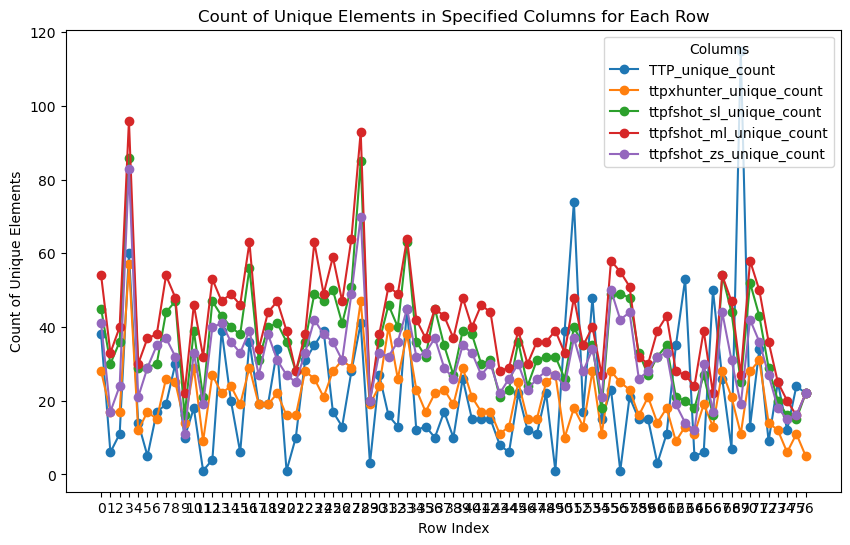

In [48]:
#df_transformed

# Function to count unique elements in a cell
def count_unique_elements(cell):
    if isinstance(cell, str):  # Check if the cell is a string
        elements = cell.split(', ')  # Split by comma and space
        return len(set(elements))  # Count unique elements
    return 0  # Return 0 if not a string

# Function to create a new DataFrame with unique counts
def create_unique_count_dataframe(df, columns):
    unique_count_data = {}
    for column in columns:
        unique_count_data[f'{column}_unique_count'] = df[column].apply(count_unique_elements)
    return pd.DataFrame(unique_count_data)

# Specify the columns to process
columns_to_process = ['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']


# Apply the function and print the result
df_counts2 = create_unique_count_dataframe(df_transformed, columns_to_process)
#print(df)

# Apply the function to each specified column to get the count of unique elements
#df_counts2 = df_transformed[['TTP', 'ttpxhunter', 'ttpfshot_sl', 'ttpfshot_ml', 'ttpfshot_zs']].applymap(count_unique_elements)

# Plotting as a line chart
plt.figure(figsize=(10, 6))
for column in df_counts2.columns:
    plt.plot(df_counts2.index, df_counts2[column], marker='o', label=column)

plt.xlabel("Row Index")
plt.ylabel("Count of Unique Elements")
plt.title("Count of Unique Elements in Specified Columns for Each Row")
plt.xticks(df_counts2.index)
plt.legend(title="Columns")
plt.show()

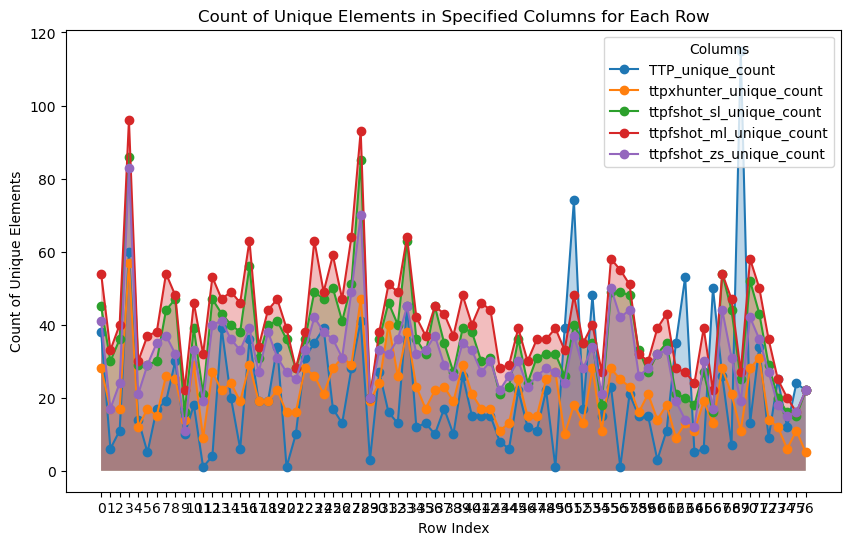

In [49]:
# Plotting as a line area chart
plt.figure(figsize=(10, 6))
for column in df_counts2.columns:
    plt.plot(df_counts2.index, df_counts2[column], marker='o', label=column)
    plt.fill_between(df_counts2.index, df_counts2[column], alpha=0.3)

plt.xlabel("Row Index")
plt.ylabel("Count of Unique Elements")
plt.title("Count of Unique Elements in Specified Columns for Each Row")
plt.xticks(df_counts2.index)
plt.legend(title="Columns")
plt.show()

In [48]:
%pip install seaborn

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

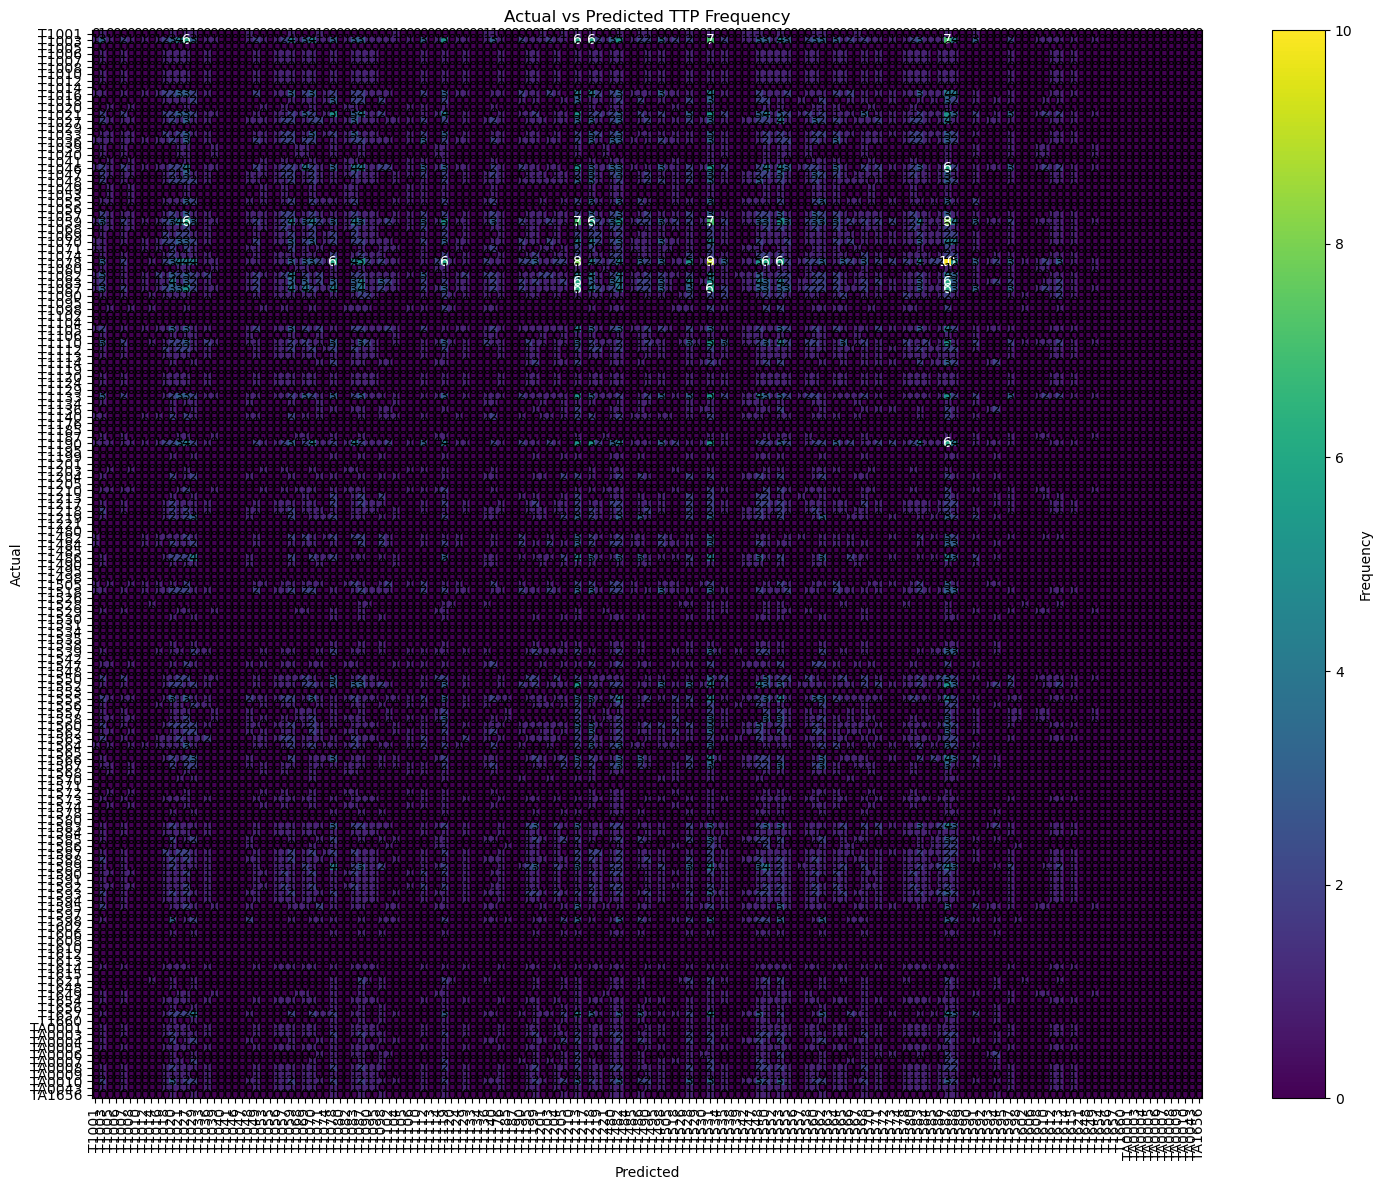

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your DataFrame (replace with your DataFrame variable)
#df = pd.read_csv('/mnt/data/your_dataframe.csv')  # Adjust if needed

# Split the TTP columns into lists (assumes they are comma-separated strings)
df_transformed['TTP'] = df_transformed['TTP'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df_transformed['ttpxhunter'] = df_transformed['ttpxhunter'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Create a list of all unique TTPs
all_ttps = sorted(set([ttp for sublist in df_transformed['TTP'] for ttp in sublist] +
                      [ttp for sublist in df_transformed['ttpxhunter'] for ttp in sublist]))

# Create a frequency matrix
freq_matrix = pd.DataFrame(0, index=all_ttps, columns=all_ttps)

# Populate the matrix with counts
for _, row in df_transformed.iterrows():
    for actual in row['TTP']:
        for predicted in row['ttpxhunter']:
            freq_matrix.at[actual, predicted] += 1

# Convert the frequency matrix to a numpy array for plotting
freq_matrix_np = freq_matrix.to_numpy()

# Plot the heatmap
plt.figure(figsize=(15, 12))
plt.imshow(freq_matrix_np, cmap='viridis', aspect='auto')
plt.colorbar(label='Frequency')

# Add labels for x and y axes
plt.xticks(ticks=np.arange(len(all_ttps)), labels=all_ttps, rotation=90)
plt.yticks(ticks=np.arange(len(all_ttps)), labels=all_ttps)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted TTP Frequency")

# Annotate each cell with the count
for i in range(len(all_ttps)):
    for j in range(len(all_ttps)):
        plt.text(j, i, freq_matrix_np[i, j], ha='center', va='center', color='white' if freq_matrix_np[i, j] > np.max(freq_matrix_np) / 2 else 'black')

plt.tight_layout()
plt.show()


In [55]:
all_ttps

[]

In [56]:
df_transformed

Unnamed: 0  \
0   https://www.cisa.gov/news-events/cybersecurity...   
1   https://www.cisa.gov/news-events/cybersecurity...   
2   https://www.cisa.gov/news-events/cybersecurity...   
3   https://www.cisa.gov/news-events/cybersecurity...   
4   https://www.cisa.gov/news-events/cybersecurity...   
5   https://www.cisa.gov/news-events/cybersecurity...   
6   https://www.cisa.gov/news-events/cybersecurity...   
7   https://www.cisa.gov/news-events/cybersecurity...   
8   https://www.cisa.gov/news-events/cybersecurity...   
9   https://www.cisa.gov/news-events/cybersecurity...   
10  https://www.cisa.gov/news-events/cybersecurity...   
11  https://www.cisa.gov/news-events/cybersecurity...   
12  https://www.cisa.gov/news-events/cybersecurity...   
13  https://www.cisa.gov/news-events/cybersecurity...   
14  https://www.cisa.gov/news-events/cybersecurity...   

                                              RawText TTP  \
0   \n\n\n\n\n\n\nActions to take today to mitigat...  []   
1   \n\n\n\nHow SVR-Attributed Actors are Adapting...  []   
2   \n\n\n\n\n\n\nActions to take today to mitigat...  []   
3   \n\n\n\n\n\n\nActions to take today to mitigat...  []   
4   \n\n\n\n\n\n\nActions to take today to mitigat...  []   
5   \n\n\n\n\n\n\nActions to take today to mitigat...  []   
6   \n\n\n\n\n\n\nActions to take today to mitigat...  []   
7   \n\n\n\n\n\n\nActions to take today to harden ...  []   
8   \n\n\n\nSUMMARY\nThe U.S. Federal Bureau of In...  []   
9   \n\n\n\nThe Russia-based actor is targeting or...  []   
10  \n\n\n\n\n\n\nActions to take today to mitigat...  []   
11  \n\n\n\n\n\n\nActions to take today to mitigat...  []   
12  \n\n\n\nSUMMARY\nNote: This joint Cybersecurit...  []   
13  \n\n\n\nSUMMARY\nThe Federal Bureau of Investi...  []   
14  \n\n\n\n\n\n\nActions to take today to mitigat...  []   

                                            CleanText ttpxhunter  \
0   \n\n\n\n\n\n\nActions to take today to mitigat...         []   
1   \n\n\n\nHow SVR-Attributed Actors are Adapting...         []   
2   \n\n\n\n\n\n\nActions to take today to mitigat...         []   
3   \n\n\n\n\n\n\nActions to take today to mitigat...         []   
4   \n\n\n\n\n\n\nActions to take today to mitigat...         []   
5   \n\n\n\n\n\n\nActions to take today to mitigat...         []   
6   \n\n\n\n\n\n\nActions to take today to mitigat...         []   
7   \n\n\n\n\n\n\nActions to take today to harden ...         []   
8   \n\n\n\nSUMMARY\nThe U.S. Federal Bureau of In...         []   
9   \n\n\n\nThe Russia-based actor is targeting or...         []   
10  \n\n\n\n\n\n\nActions to take today to mitigat...         []   
11  \n\n\n\n\n\n\nActions to take today to mitigat...         []   
12  \n\n\n\nSUMMARY\nNote: This joint Cybersecurit...         []   
13  \n\n\n\nSUMMARY\nThe Federal Bureau of Investi...         []   
14  \n\n\n\n\n\n\nActions to take today to mitigat...         []   

                                          ttpfshot_sl  \
0   T1005, T1598, T1021, T1076, T1562, T1059, T165...   
1   T1589, T1527, T1098, T1071, T1070, T1029, T111...   
2   T1157, T1542, T1531, T1012, T1021, T1562, T113...   
3   T1076, T1133, T1059, T1569, T1550, T1539, T118...   
4   T1190, T1562, T1589, T1608, T1555, T1550, T107...   
5   T1598, T1534, T1003, T1562, T1657, T1219, T107...   
6   T1003, T1190, T1562, T1133, T1059, T1657, T109...   
7   T1566, T1598, T1534, T1003, T1021, T1187, T119...   
8   T1566, T1003, T1190, T1562, T1589, T1059, T111...   
9   T1585, T1566, T1598, T1614, T1539, T1583, T159...   
10  T1003, T1190, T1562, T1059, T1573, T1482, T108...   
11  T1598, T1190, T1562, T1589, T1098, T1111, T121...   
12  T1003, T1012, T1021, T1190, T1562, T1589, T105...   
13  T1005, T1566, T1021, T1538, T1190, T1562, T113...   
14  T1566, T1021, T1076, T1190, T1562, T1133, T105...   

                                          ttpfshot_ml  \
0   T1005, T1566, T1003, T1598, T1021, T1076, T119...   
1   T1566, T1499, T1589, T1527, T1098

### Metrics 

In [58]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score

def calculate_metrics(df, y_true_col, y_pred_col, key):
    # Convert columns to lists of sets
    y_true = df[y_true_col].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()#.tolist()  # Convert strings to sets
    y_pred = df[y_pred_col].tolist()

    # Define all unique TTPs across the entire dataset
    all_ttps = set.union(*y_true, *y_pred)

    # Use MultiLabelBinarizer to transform labels
    mlb = MultiLabelBinarizer(classes=list(all_ttps))
    y_true_bin = mlb.fit_transform(y_true)
    y_pred_bin = mlb.transform(y_pred)

    # Calculate metrics
    metrics = {
        "subset_accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "hamming_accuracy": 1 - hamming_loss(y_true_bin, y_pred_bin),
        "f1_micro": f1_score(y_true_bin, y_pred_bin, average='micro'),
        "f1_macro": f1_score(y_true_bin, y_pred_bin, average='macro'),
        "precision_micro": precision_score(y_true_bin, y_pred_bin, average='micro'),
        "precision_macro": precision_score(y_true_bin, y_pred_bin, average='macro'),
        "recall_micro": recall_score(y_true_bin, y_pred_bin, average='micro'),
        "recall_macro": recall_score(y_true_bin, y_pred_bin, average='macro')
    }
    
    # Return the metrics dictionary for the specified key
    return {key: metrics}



def calculate_single_label_metrics(df, y_true_col, y_pred_col, key):
    # Convert columns to lists (no need for sets or multi-label encoding)
    y_true = df[y_true_col].tolist()
    y_pred = df[y_pred_col].tolist()

    # Calculate metrics for single-label classification
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "hamming_accuracy": 1 - hamming_loss(y_true, y_pred),
        "f1_micro": f1_score(y_true, y_pred, average='micro'),
        "f1_macro": f1_score(y_true, y_pred, average='macro'),
        "precision_micro": precision_score(y_true, y_pred, average='micro'),
        "precision_macro": precision_score(y_true, y_pred, average='macro'),
        "recall_micro": recall_score(y_true, y_pred, average='micro'),
        "recall_macro": recall_score(y_true, y_pred, average='macro')
    }
    
    # Return the metrics dictionary for the specified key
    return {key: metrics}


In [59]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score

def calculate_metrics2(df, y_true_col, y_pred_col, key):
    # Convert columns to lists of sets
    y_true = df[y_true_col].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
    y_pred = df[y_pred_col].tolist()

    # Define all unique TTPs across the entire dataset
    all_ttps = set.union(*y_true, *y_pred)

    # Use MultiLabelBinarizer to transform labels
    mlb = MultiLabelBinarizer(classes=list(all_ttps))
    y_true_bin = mlb.fit_transform(y_true)
    y_pred_bin = mlb.transform(y_pred)

    # Calculate metrics
    metrics = {
        "subset_accuracy": accuracy_score(y_true_bin, y_pred_bin),
        "hamming_accuracy": 1 - hamming_loss(y_true_bin, y_pred_bin),
        "f1_micro": f1_score(y_true_bin, y_pred_bin, average='micro'),
        "f1_macro": f1_score(y_true_bin, y_pred_bin, average='macro'),
        "f1_weighted": f1_score(y_true_bin, y_pred_bin, average='weighted'),
        "precision_micro": precision_score(y_true_bin, y_pred_bin, average='micro'),
        "precision_macro": precision_score(y_true_bin, y_pred_bin, average='macro'),
        "recall_micro": recall_score(y_true_bin, y_pred_bin, average='micro'),
        "recall_macro": recall_score(y_true_bin, y_pred_bin, average='macro'),
        "jaccard_micro": jaccard_score(y_true_bin, y_pred_bin, average='micro'),
        "jaccard_macro": jaccard_score(y_true_bin, y_pred_bin, average='macro')
    }
    
    # Return the metrics dictionary for the specified key
    return {key: metrics}


def calculate_single_label_metrics2(df, y_true_col, y_pred_col, key):
    # Convert columns to lists (no need for sets or multi-label encoding)
    y_true = df[y_true_col].tolist()
    y_pred = df[y_pred_col].tolist()

    # Calculate metrics for single-label classification
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "hamming_accuracy": 1 - hamming_loss(y_true, y_pred),
        "f1_micro": f1_score(y_true, y_pred, average='micro'),
        "f1_macro": f1_score(y_true, y_pred, average='macro'),
        "f1_weighted": f1_score(y_true, y_pred, average='weighted'),
        "precision_micro": precision_score(y_true, y_pred, average='micro'),
        "precision_macro": precision_score(y_true, y_pred, average='macro'),
        "recall_micro": recall_score(y_true, y_pred, average='micro'),
        "recall_macro": recall_score(y_true, y_pred, average='macro'),
        "jaccard_micro": jaccard_score(y_true, y_pred, average='micro'),
        "jaccard_macro": jaccard_score(y_true, y_pred, average='macro')
    }
    
    # Return the metrics dictionary for the specified key
    return {key: metrics}

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

def plot_combined_confusion_matrix(df, y_true_col, y_pred_col):
    # Convert columns to lists of sets
    y_true = df[y_true_col].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
    y_pred = df[y_pred_col].tolist()

    # Define all unique TTPs across the entire dataset
    all_ttps = sorted(set.union(*y_true, *y_pred))

    # Use MultiLabelBinarizer to transform labels
    mlb = MultiLabelBinarizer(classes=all_ttps)
    y_true_bin = mlb.fit_transform(y_true)
    y_pred_bin = mlb.transform(y_pred)

    # Calculate the global confusion matrix for all labels
    cm = np.zeros((len(all_ttps), len(all_ttps)), dtype=int)
    for i in range(len(y_true_bin)):
        for true_idx in np.where(y_true_bin[i] == 1)[0]:
            for pred_idx in np.where(y_pred_bin[i] == 1)[0]:
                cm[true_idx, pred_idx] += 1

    # Plot the combined confusion matrix
    plt.figure(figsize=(120, 100))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for All Labels')
    plt.colorbar()
    tick_marks = np.arange(len(all_ttps))
    plt.xticks(tick_marks, all_ttps, rotation=90)
    plt.yticks(tick_marks, all_ttps)

    # Annotate the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_combined_confusion_matrix(df, 'TTP', 'ttpxhunter')


In [61]:
plot_combined_confusion_matrix(df_reports, 'TTP', 'ttpxhunter')

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def plot_actual_vs_predicted_heatmap(df, y_true_col, y_pred_col):
    # Convert columns to lists of sets
    y_true = df[y_true_col].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
    y_pred = df[y_pred_col].tolist()

    # Define all unique TTPs across the entire dataset
    all_ttps = sorted(set.union(*y_true, *y_pred))

    # Use MultiLabelBinarizer to transform labels
    mlb = MultiLabelBinarizer(classes=all_ttps)
    y_true_bin = mlb.fit_transform(y_true)
    y_pred_bin = mlb.transform(y_pred)

    # Create a DataFrame to track actual vs predicted counts
    cm_matrix = pd.DataFrame(0, index=all_ttps, columns=all_ttps)
    for i in range(len(y_true_bin)):
        actual_indices = np.where(y_true_bin[i] == 1)[0]
        predicted_indices = np.where(y_pred_bin[i] == 1)[0]
        for actual in actual_indices:
            for predicted in predicted_indices:
                cm_matrix.iloc[actual, predicted] += 1

    # Plot the heatmap
    plt.figure(figsize=(15, 12))
    plt.imshow(cm_matrix, cmap='viridis', aspect='auto')
    plt.title('Actual vs Predicted Class Frequency')
    plt.colorbar(label='Frequency')
    tick_marks = np.arange(len(all_ttps))
    plt.xticks(tick_marks, all_ttps, rotation=90)
    plt.yticks(tick_marks, all_ttps)

    # Annotate the cells
    for i in range(cm_matrix.shape[0]):
        for j in range(cm_matrix.shape[1]):
            if cm_matrix.iloc[i, j] > 0:
                plt.text(j, i, cm_matrix.iloc[i, j], ha='center', va='center', 
                         color='white' if cm_matrix.iloc[i, j] > cm_matrix.values.max() / 2 else 'black')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_actual_vs_predicted_heatmap(df_reports, 'TTP', 'ttpxhunter')



In [45]:
#plot_actual_vs_predicted_heatmap(df_transformed, 'TTP', 'ttpxhunter')

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def plot_top_10_actual_vs_predicted_heatmap(df, y_true_col, y_pred_col):
    # Convert columns to lists of sets
    y_true = df[y_true_col].apply(lambda x: eval(x) if isinstance(x, str) else x).tolist()
    y_pred = df[y_pred_col].tolist()

    # Define all unique TTPs across the entire dataset
    all_ttps = sorted(set.union(*y_true, *y_pred))

    # Use MultiLabelBinarizer to transform labels
    mlb = MultiLabelBinarizer(classes=all_ttps)
    y_true_bin = mlb.fit_transform(y_true)
    y_pred_bin = mlb.transform(y_pred)

    # Create a DataFrame to track actual vs predicted counts
    cm_matrix = pd.DataFrame(0, index=all_ttps, columns=all_ttps)
    for i in range(len(y_true_bin)):
        actual_indices = np.where(y_true_bin[i] == 1)[0]
        predicted_indices = np.where(y_pred_bin[i] == 1)[0]
        for actual in actual_indices:
            for predicted in predicted_indices:
                cm_matrix.iloc[actual, predicted] += 1

    # Find the 10 most frequent classes
    total_counts = cm_matrix.sum(axis=1) + cm_matrix.sum(axis=0)
    top_10_labels = total_counts.nlargest(50).index

    # Filter the matrix to include only the top 10 most frequent classes
    cm_matrix_top_10 = cm_matrix.loc[top_10_labels, top_10_labels]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_matrix_top_10, cmap='viridis', aspect='auto')
    plt.title('Top 10 Actual vs Predicted Class Frequency')
    plt.colorbar(label='Frequency')
    tick_marks = np.arange(len(top_10_labels))
    plt.xticks(tick_marks, top_10_labels, rotation=90)
    plt.yticks(tick_marks, top_10_labels)

    # Annotate the cells
    for i in range(cm_matrix_top_10.shape[0]):
        for j in range(cm_matrix_top_10.shape[1]):
            if cm_matrix_top_10.iloc[i, j] > 0:
                plt.text(j, i, cm_matrix_top_10.iloc[i, j], ha='center', va='center', 
                         color='white' if cm_matrix_top_10.iloc[i, j] > cm_matrix_top_10.values.max() / 2 else 'black')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_10_actual_vs_predicted_heatmap(df_reports, 'TTP', 'ttpxhunter')


In [126]:
plot_top_10_actual_vs_predicted_heatmap(df_reports, 'TTP', 'ttpfshot_sl')

### Analysis for only 2 Reports

In [63]:

all_scores1 = {
    "ttpxhunter" : calculate_metrics2(df_reports[:2], 'TTP', 'ttpxhunter', 'ttpxhunter'),
    "ttpfshot_sl" : calculate_metrics2(df_reports[:2], 'TTP', 'ttpfshot_sl', 'ttpfshot_sl'),
    "ttpfshot_ml" : calculate_metrics2(df_reports[:2], 'TTP', 'ttpfshot_ml', 'ttpfshot_ml'),
    "ttpfshot_zs" : calculate_metrics2(df_reports[:2], 'TTP', 'ttpfshot_zs', 'ttpfshot_zs')
}

#scores_df = pd.DataFrame(all_scores)#.transpose()

#print(scores_df)

flattened_data1 = {outer_key: inner_dict[outer_key] for outer_key, inner_dict in all_scores1.items()}

# Create DataFrame
scores_df1 = pd.DataFrame(flattened_data1).transpose()
scores_df1

/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/py

subset_accuracy  hamming_accuracy  f1_micro  f1_macro  \
ttpxhunter               0.0          0.506024  0.145833  0.080321   
ttpfshot_sl              0.0          0.551724  0.287671  0.178161   
ttpfshot_ml              0.0          0.545455  0.250000  0.146465   
ttpfshot_zs              0.0          0.505495  0.181818  0.091575   

             f1_weighted  precision_micro  precision_macro  recall_micro  \
ttpxhunter      0.130719         0.155556         0.078313      0.137255   
ttpfshot_sl     0.405229         0.221053         0.176724      0.411765   
ttpfshot_ml     0.392157         0.183486         0.147727      0.392157   
ttpfshot_zs     0.183007         0.169492         0.087912      0.196078   

             recall_macro  jaccard_micro  jaccard_macro  
ttpxhunter       0.084337       0.078652       0.078313  
ttpfshot_sl      0.181034       0.168000       0.176724  
ttpfshot_ml      0.147727       0.142857       0.143939  
ttpfshot_zs      0.098901       0.100000       0.087912

In [53]:

all_scores = {
    "ttpxhunter" : calculate_metrics2(df_reports, 'TTP', 'ttpxhunter', 'ttpxhunter'),
    "ttpfshot_sl" : calculate_metrics2(df_reports, 'TTP', 'ttpfshot_sl', 'ttpfshot_sl'),
    "ttpfshot_ml" : calculate_metrics2(df_reports, 'TTP', 'ttpfshot_ml', 'ttpfshot_ml'),
    "ttpfshot_zs" : calculate_metrics2(df_reports, 'TTP', 'ttpfshot_zs', 'ttpfshot_zs')
}

#scores_df = pd.DataFrame(all_scores)#.transpose()

#print(scores_df)

flattened_data = {outer_key: inner_dict[outer_key] for outer_key, inner_dict in all_scores.items()}

# Create DataFrame
scores_df = pd.DataFrame(flattened_data).transpose()
scores_df

/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/py

subset_accuracy  hamming_accuracy  f1_micro  f1_macro  \
ttpxhunter               0.0          0.913749  0.113739  0.045441   
ttpfshot_sl              0.0          0.917932  0.245893  0.123716   
ttpfshot_ml              0.0          0.933692  0.217434  0.079189   
ttpfshot_zs              0.0          0.913244  0.183461  0.081528   

             f1_weighted  precision_micro  precision_macro  recall_micro  \
ttpxhunter      0.092810         0.125310         0.051122      0.104124   
ttpfshot_sl     0.278828         0.189219         0.116049      0.351031   
ttpfshot_ml     0.265266         0.158554         0.074030      0.345876   
ttpfshot_zs     0.167886         0.163315         0.106217      0.209278   

             recall_macro  jaccard_micro  jaccard_macro  
ttpxhunter       0.074060       0.060299       0.028703  
ttpfshot_sl      0.174198       0.140181       0.087286  
ttpfshot_ml      0.117342       0.121978       0.054025  
ttpfshot_zs      0.122089       0.100995       0.053954

In [54]:
scores_df#.iloc[:, 1:]#.columns#.T

subset_accuracy  hamming_accuracy  f1_micro  f1_macro  \
ttpxhunter               0.0          0.913749  0.113739  0.045441   
ttpfshot_sl              0.0          0.917932  0.245893  0.123716   
ttpfshot_ml              0.0          0.933692  0.217434  0.079189   
ttpfshot_zs              0.0          0.913244  0.183461  0.081528   

             f1_weighted  precision_micro  precision_macro  recall_micro  \
ttpxhunter      0.092810         0.125310         0.051122      0.104124   
ttpfshot_sl     0.278828         0.189219         0.116049      0.351031   
ttpfshot_ml     0.265266         0.158554         0.074030      0.345876   
ttpfshot_zs     0.167886         0.163315         0.106217      0.209278   

             recall_macro  jaccard_micro  jaccard_macro  
ttpxhunter       0.074060       0.060299       0.028703  
ttpfshot_sl      0.174198       0.140181       0.087286  
ttpfshot_ml      0.117342       0.121978       0.054025  
ttpfshot_zs      0.122089       0.100995       0.053954

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Transpose the DataFrame so metrics are on the x-axis and models are grouped within each metric
scores_df_T = scores_df.T

scores_df_T = scores_df_T.iloc[1:]#.reset_index(drop=True)

# Define the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Number of metrics and models
metrics = scores_df_T.index
models = scores_df_T.columns
num_metrics = len(metrics)
num_models = len(models)

# Define bar width and positions for each group
bar_width = 0.2
x = np.arange(num_metrics)  # Positions for each metric group

# Plot each model's data as separate bars within each metric group
for i, model in enumerate(models):
    ax.bar(x + i * bar_width, scores_df_T[model], width=bar_width, label=model)

# Set labels and title
ax.set_title("Grouped Bar Chart of Evaluation Metrics Across Models")
ax.set_xlabel("Metrics")
ax.set_ylabel("Metric Values")
ax.set_xticks(x + bar_width * (num_models - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend(title="Model Versions", loc="upper right")

# Display grid and tighten layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


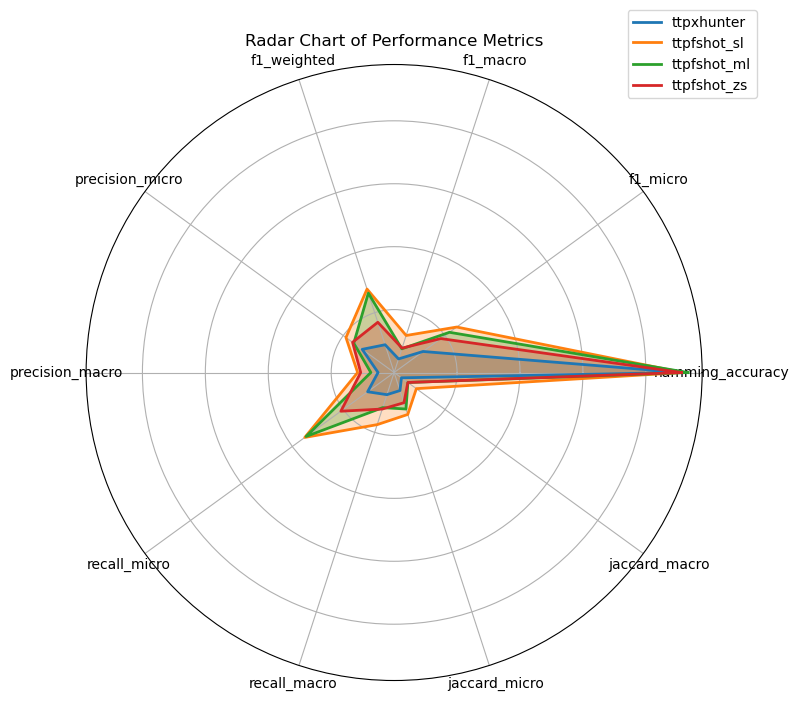

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Define labels for each metric
scores_df_filtered = scores_df.iloc[:, 1:]
labels = scores_df_filtered.columns
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Plot each model as a polygon on the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, (model, row) in enumerate(scores_df_filtered.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]  # Complete the loop to connect the last point to the first
    
    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Add metric labels to each axis
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])  # Exclude the last angle as it's a duplicate
ax.set_xticklabels(labels)

plt.title("Radar Chart of Performance Metrics")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


## DSB Benchmarking - TTPXHunter vs. TTPFShot

In [40]:


df_dsb = pd.read_csv('../DATA/TTPHunter_dataset.csv')
print(df_dsb.head())

train1, test1 = train_test_split(df_dsb, test_size=0.2, random_state=0)
print(len(test1))

       Domain Technique ID                                     Technique Name  \
0  Enterprise        T1543   Create or Modify System Process: Windows Service   
1  Enterprise        T1562  Impair Defenses: Disable or Modify System Fire...   
2  Enterprise        T1036           Masquerading: Masquerade Task or Service   
3  Enterprise        T1036    Masquerading: Match Legitimate Name or Location   
4  Enterprise        T1588                          Obtain Capabilities: Tool   

                                           Sentences  
0  Carbanak malware installs itself as a service ...  
1  Carbanak may use netsh to add local firewall r...  
2  Carbanak has copied legitimate service names t...  
3  Carbanak has named malware "svchost.exe," whic...  
4  Carbanak has obtained and used open-source too...  
1678


In [42]:
# create documents from df rows
docs_dsb = []
for index, row in train1.iterrows():
    doc = Document(page_content=row["Sentences"], metadata={"TTP_ID": row["Technique ID"]})
    docs_dsb.append(doc)

print(len(docs_dsb))

6709


In [56]:
# init DSB vector DB
db_dsb = FAISS.from_documents(docs_dsb, embeddings2)

### Run Benchmark

In [93]:
predicted_labels_ttpfshot_sl_dsc = []
predicted_labels_ttpfshot_sl_dsb = []
predicted_labels_ttpXhunter_sl_dsb = []

counter = 1
total_sentences = len(test1)

for index, row in test1.iterrows():
    
    #print("sentence nr: ", index)
    print("Processing sentence number:", counter, " out of: ", str(total_sentences))
    
    text_to_classify = row["Sentences"]
    
    # DSA istead of DSC
    ttpfshot_sl_dsc = ttf_shot_predict([text_to_classify], "SINGLE_LABEL", llm, db3)
    ttpfshot_sl_dsb = ttf_shot_predict([text_to_classify], "SINGLE_LABEL", llm, db_dsb)
    ttpxhunter_ttps, ttp_names = extract_ttp_from_sentences(sent_tokenize(text_to_classify), th, label_dict, ttpid2name)
    #print(ttpfshot_sl)
    
    predicted_labels_ttpfshot_sl_dsc.append(list(ttpfshot_sl_dsc)[0])
    predicted_labels_ttpfshot_sl_dsb.append(list(ttpfshot_sl_dsb)[0])
    predicted_labels_ttpXhunter_sl_dsb.append(ttpxhunter_ttps[0])
    
    counter += 1

Processing sentence number: 1  out of:  1678
Processing sentence number: 2  out of:  1678
Processing sentence number: 3  out of:  1678
Processing sentence number: 4  out of:  1678
Processing sentence number: 5  out of:  1678
Processing sentence number: 6  out of:  1678
Processing sentence number: 7  out of:  1678
Processing sentence number: 8  out of:  1678
Processing sentence number: 9  out of:  1678
Processing sentence number: 10  out of:  1678
Processing sentence number: 11  out of:  1678
Processing sentence number: 12  out of:  1678
Processing sentence number: 13  out of:  1678
Processing sentence number: 14  out of:  1678
Processing sentence number: 15  out of:  1678
Processing sentence number: 16  out of:  1678
Processing sentence number: 17  out of:  1678
Processing sentence number: 18  out of:  1678
Processing sentence number: 19  out of:  1678
Processing sentence number: 20  out of:  1678
Processing sentence number: 21  out of:  1678
Processing sentence number: 22  out of:  16

KeyboardInterrupt: 

### Evaluate

In [95]:
print(predicted_labels_ttpfshot_sl_dsc)
print(predicted_labels_ttpfshot_sl_dsb)
print(predicted_labels_ttpXhunter_sl_dsb)
test1["Technique ID"]
dsb_data = {
    "ttpxhunter":predicted_labels_ttpXhunter_sl_dsb,
    "ttpfshot_sl_dsb":predicted_labels_ttpfshot_sl_dsb,
    # this is DSA
    "ttpfshot_sl_dsc":predicted_labels_ttpfshot_sl_dsc,
    "TTP":test1["Technique ID"].head(len(predicted_labels_ttpXhunter_sl_dsb)).values
}

df_reports_dsb = pd.DataFrame(dsb_data)

df_reports_dsb['ttpfshot_sl_dsc'] = df_reports_dsb['ttpfshot_sl_dsc'].apply(lambda x: x.split('.')[0])

# Display the DataFrame
print(df_reports_dsb)

['T1082', 'T1036.005', 'T1012', 'T1056.001', 'T1113', 'T1036.003', 'T1053.005', 'T1106', 'T1071.001', 'T1518.001', 'T1083', 'T1071.001', 'T1562.001', 'T1021.006', 'T1074.001', 'T1112', 'T1218.007', 'T1057', 'T1059.001', 'T1106', 'T1016', 'T1102.001', 'T1547.001', 'T1562.004', 'T1069.001', 'T1555.003', 'T1562.001', 'T1056.001', 'T1204.002', 'T1140', 'T1021.001', 'T1059.005', 'T1036.001', 'T1071.001', 'T1105', 'T1553.006', 'T1574.002', 'T1113', 'T1070.004', 'T1003.001', 'T1012', 'T1027.010', 'T1041', 'T1102.002', 'T1562.001', 'T1071.001', 'T1003.001', 'T1071.001', 'T1140', 'T1059.003', 'T1105', 'T1003.001', 'T1005', 'T1543.003', 'T1547.008', 'T1573', 'T1555.003', 'T1059.007', 'T1041', 'T1547.001']
['T1082', 'T1036', 'T1012', 'T1056', 'T1113', 'T1036', 'T1053', 'T1106', 'T1071', 'T1518', 'T1083', 'T1071', 'T1562', 'T1021', 'T1074', 'T1112', 'T1218', 'T1057', 'T1059', 'T1055', 'T1016', 'T1102', 'T1547', 'T1562', 'T1069', 'T1555', 'T1562', 'T1056', 'T1204', 'T1140', 'T1021', 'T1059', 'T1553

In [96]:
df_reports_dsb

ttpxhunter ttpfshot_sl_dsb ttpfshot_sl_dsc    TTP
0       T1082           T1082           T1082  T1082
1       T1547           T1036           T1036  T1036
2       T1012           T1012           T1012  T1012
3       T1056           T1056           T1056  T1056
4       T1113           T1113           T1113  T1113
5       T1036           T1036           T1036  T1036
6       T1053           T1053           T1053  T1053
7       T1106           T1106           T1106  T1106
8       T1071           T1071           T1071  T1071
9       T1518           T1518           T1518  T1518
10      T1083           T1083           T1083  T1083
11      T1071           T1071           T1071  T1071
12      T1562           T1562           T1562  T1562
13      T1021           T1021           T1021  T1021
14      T1074           T1074           T1074  T1074
15      T1112           T1112           T1112  T1112
16      T1140           T1218           T1218  T1218
17      T1057           T1057           T1057  T1057
18      T1059           T1059           T1059  T1059
19      T1106           T1055           T1106  T1106
20      T1016           T1016           T1016  T1016
21      T1102           T1102           T1102  T1102
22      T1547           T1547           T1547  T1547
23      T1562           T1562           T1562  T1562
24      T1069           T1069           T1069  T1069
25      T1555           T1555           T1555  T1555
26      T1562           T1562           T1562  T1562
27      T1056           T1056           T1056  T1056
28      T1204           T1204           T1204  T1204
29      T1140           T1140           T1140  T1140
30      T1021           T1021           T1021  T1021
31      T1059           T1059           T1059  T1059
32      T1036           T1553           T1036  T1036
33      T1071           T1071           T1071  T1071
34      T1105           T1105           T1105  T1105
35      T1553           T1553           T1553  T1553
36      T1574           T1574           T1574  T1574
37      T1113           T1113           T1113  T1113
38      T1070           T1070           T1070  T1070
39      T1003           T1003           T1003  T1003
40      T1012           T1012           T1012  T1012
41      T1027           T1027           T1027  T1027
42      T1041           T1041           T1041  T1041
43      T1102           T1102           T1102  T1102
44      T1562           T1562           T1562  T1562
45      T1071           T1071           T1071  T1071
46      T1003           T1003           T1003  T1003
47      T1071           T1071           T1071  T1071
48      T1140           T1140           T1140  T1140
49      T1059           T1059           T1059  T1059
50      T1105           T1105           T1105  T1105
51      T1003           T1003           T1003  T1003
52      T1005           T1005           T1005  T1005
53      T1543           T1543           T1543  T1543
54      T1569           T1574           T1547  T1547
55      T1573           T1573           T1573  T1573
56      T1555           T1555           T1555  T1555
57      T1059           T1059           T1059  T1059
58      T1041           T1005           T1041  T1041
59      T1547           T1547           T1547  T1547

In [99]:
all_scores_dsb = {
    "ttpxhunter" : calculate_single_label_metrics(df_reports_dsb, 'TTP', 'ttpxhunter', 'ttpxhunter'),
    "ttpfshot_sl_dsb" : calculate_single_label_metrics(df_reports_dsb, 'TTP', 'ttpfshot_sl_dsb', 'ttpfshot_sl_dsb'),
    "ttpfshot_sl_dsa" : calculate_single_label_metrics(df_reports_dsb, 'TTP', 'ttpfshot_sl_dsc', 'ttpfshot_sl_dsa'),
}

#scores_df = pd.DataFrame(all_scores)#.transpose()

#print(scores_df)

flattened_data_dsb = {outer_key: inner_dict[outer_key] for outer_key, inner_dict in all_scores_dsb.items()}

# Create DataFrame
scores_df = pd.DataFrame(flattened_data_dsb).transpose()
scores_df

/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hamzicd/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy  hamming_accuracy  f1_micro  f1_macro  \
ttpxhunter       0.950000          0.950000  0.950000  0.921905   
ttpfshot_sl_dsb  0.933333          0.933333  0.933333  0.912381   
ttpfshot_sl_dsa  1.000000          1.000000  1.000000  1.000000   

                 precision_micro  precision_macro  recall_micro  recall_macro  
ttpxhunter              0.950000         0.923810      0.950000       0.92381  
ttpfshot_sl_dsb         0.933333         0.928571      0.933333       0.92381  
ttpfshot_sl_dsa         1.000000         1.000000      1.000000       1.00000

In [1]:
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'